# Cell-Cell interaction Analysis using NCEM  
### Spatial pancreas  
Annotation of dissociated data from npod by Rebecca Melton - Gaulton's lab 

### Pre-requisites

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np

import scanpy as sc
import squidpy as sq
import ncem as nc

import matplotlib.pyplot as plt

sc.settings.set_figure_params(dpi=80, facecolor="white")

2024-08-20 11:19:56.655720: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-20 11:19:59.257006: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-20 11:20:05.118226: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-20 11:20:28.795567: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
nc.__version__

'0.1.5'

### Load data

In [3]:
folder = '/lustre/groups/ml01/workspace/sara.jimenez/spatial_pancreas_data/preprocessed_data/data4downstream/'
adata_10 = sc.read(folder+'adata_fov_10_npod_annotation.h5ad')
adata_12 = sc.read(folder+'adata_fov_12_npod_annotation.h5ad')
adata_10,adata_12

/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/anndata/__init__.py:55: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/anndata/__init__.py:55: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


(AnnData object with n_obs × n_vars = 4423 × 979
     obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.GCG', 'Max.GCG', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'condition', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_NegPrb', 'log1p_total_counts_NegPrb', 'pct_counts_NegPrb', 'n_genes', 'cell_type_coarse', 'CellTypes_max'
     var: 'NegPrb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
     uns: 'CellTypes_max_colors', 'cell_type_coarse_colors', 'log1p', 'neighbors', 'pca', 'spatial', 'umap'
     obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_fov'
     varm: 'PCs'
     layers: 'cou

In [4]:
adata_10.obs['CellTypes_max'].cat.categories

Index(['Acinar_basal', 'Acinar_highEnz', 'Acinar_sigdiff', 'Acinar_signal',
       'Activated_Stellate', 'Alpha', 'Bcells', 'Beta', 'Delta', 'Ductal',
       'Endothelial', 'LymphEndo', 'MUC5b_Ductal', 'Macrophage', 'Mast',
       'Quiescent_Stellate', 'Schwann', 'Tcells'],
      dtype='object')

In [5]:
adata_12.obs['CellTypes_max'].cat.categories

Index(['Acinar_basal', 'Acinar_highEnz', 'Acinar_sigdiff', 'Acinar_signal',
       'Activated_Stellate', 'Alpha', 'Bcells', 'Beta', 'Delta', 'Ductal',
       'Endothelial', 'LymphEndo', 'MUC5b_Ductal', 'Macrophage', 'Mast',
       'Quiescent_Stellate', 'Schwann', 'Tcells'],
      dtype='object')

In [25]:
CellTypes_max_10 = adata_10.obs['CellTypes_max']
CellTypes_max_12 = adata_12.obs['CellTypes_max']

new_order = ['Acinar_basal', 'Acinar_highEnz', 'Acinar_signal', 'Acinar_sigdiff', 'Ductal', 'MUC5b_Ductal',
             'Beta', 'Alpha', 'Delta', 'Activated_Stellate', 'Quiescent_Stellate', 'Endothelial', 'LymphEndo', 
             'Macrophage', 'Tcells',  'Schwann', 'Mast', 'Bcells']

adata_10.obs['CellTypes_max'] = pd.Categorical(CellTypes_max_10, categories=new_order, ordered=True)
adata_12.obs['CellTypes_max'] = pd.Categorical(CellTypes_max_12, categories=new_order, ordered=True)


In [26]:
print(adata_10.obs['CellTypes_max'].cat.categories)

Index(['Acinar_basal', 'Acinar_highEnz', 'Acinar_signal', 'Acinar_sigdiff',
       'Ductal', 'MUC5b_Ductal', 'Beta', 'Alpha', 'Delta',
       'Activated_Stellate', 'Quiescent_Stellate', 'Endothelial', 'LymphEndo',
       'Macrophage', 'Tcells', 'Schwann', 'Mast', 'Bcells'],
      dtype='object')


In [27]:
markers={
    'Acinar_basal':['REG1A'],
    #'Acinar_highEnz':['CTRB1'],#PRSS1
    'Acinar_signal':['SOD2'],
    'Acinar_sigdiff':['MT1X'],
    #'Ductal': ['CFTR'],
    #'MUC5b_Ductal':['MUC5B'],
    'Beta': ['INS'],
    'Alpha':['GCG'],
    'Delta': ['SST'],
    'Activated_Stellate':['COL6A3'],
    'Quiescent_Stellate': ['SPARCL1'],
    #'Endothelial':['PLVAP'],
    #'LymphEndo':['FLT4'],
    'Macrophage':['C1QB'],
    'Tcells': ['CD2'],
    #'Schwann': ['CDH19'],
    'Mast':['KIT'],
    'Bcells':['CD53']    
}

/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/scanpy/plotting/_matrixplot.py:143: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  values_df = self.obs_tidy.groupby(level=0).mean()


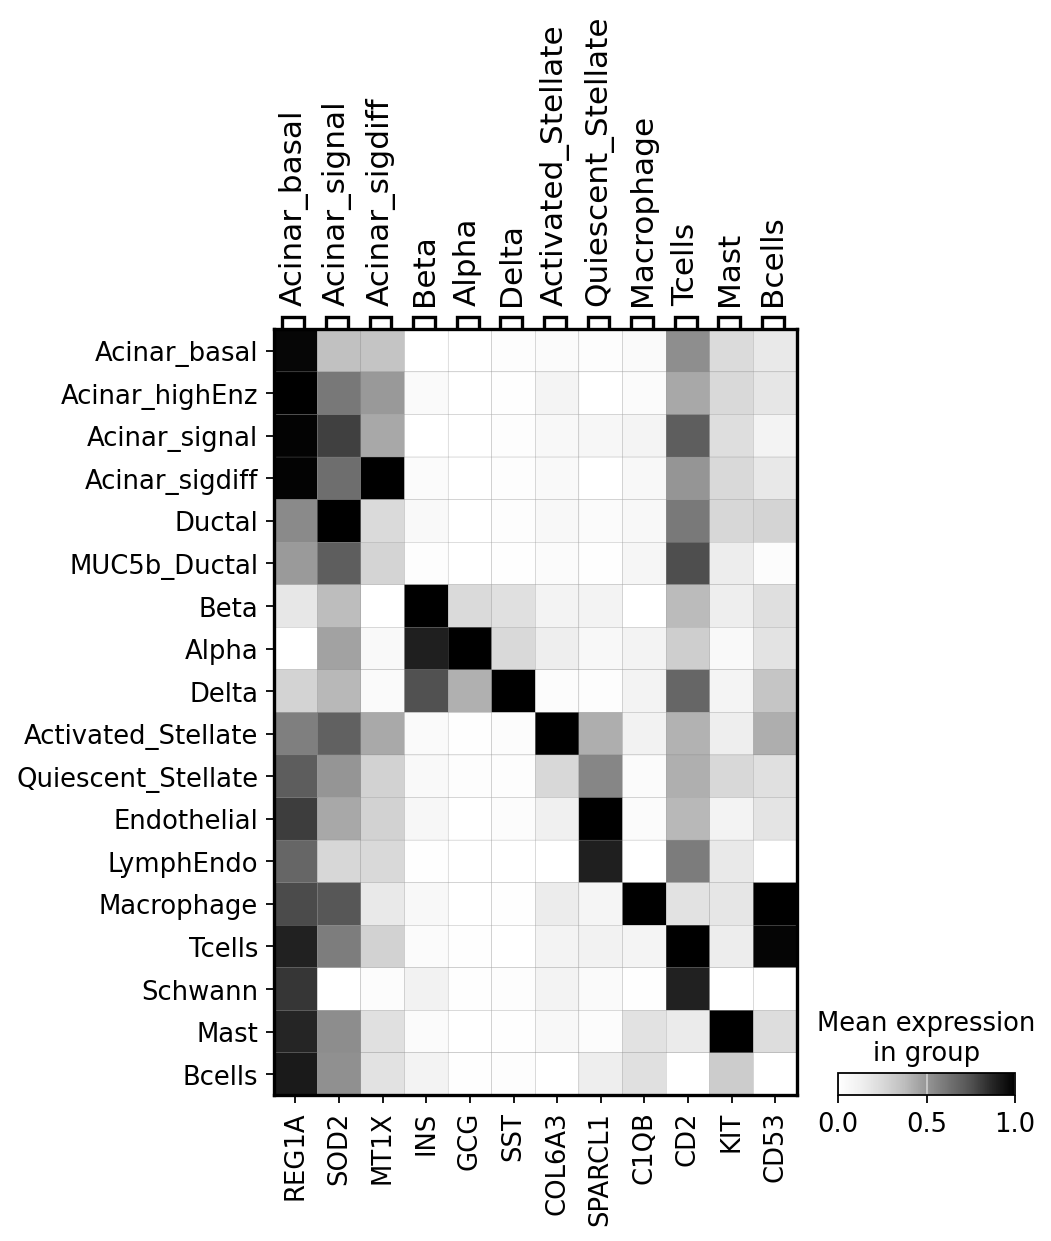

/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/scanpy/plotting/_matrixplot.py:143: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  values_df = self.obs_tidy.groupby(level=0).mean()


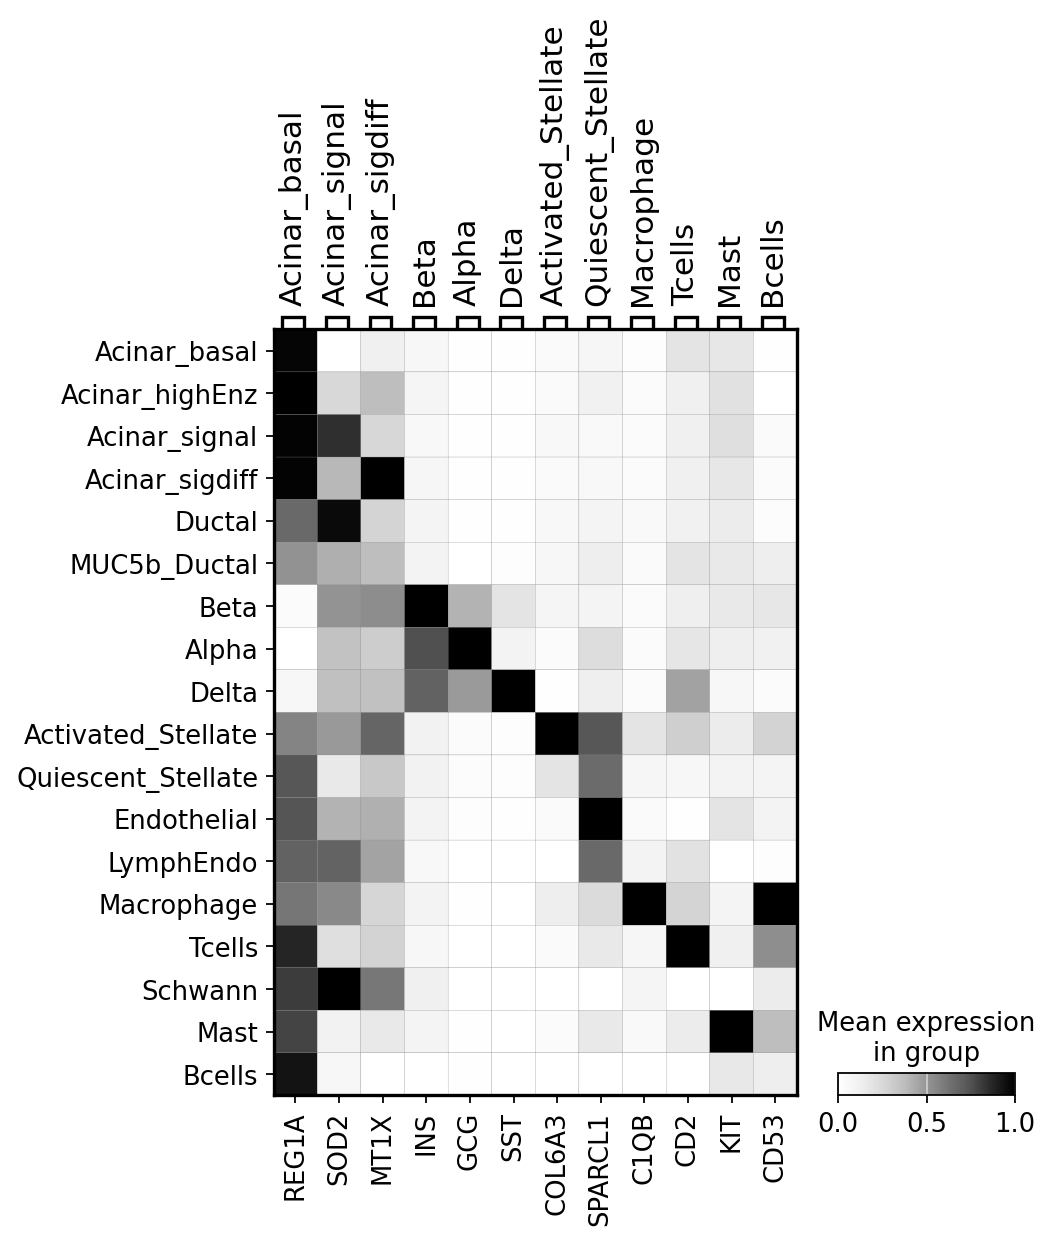

In [28]:
sc.pl.matrixplot(adata_10, markers,groupby='CellTypes_max', cmap='Greys',standard_scale='var')
sc.pl.matrixplot(adata_12, markers,groupby='CellTypes_max', cmap='Greys',standard_scale='var')

### Data Exploration

/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_map)
/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_map)
/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is 

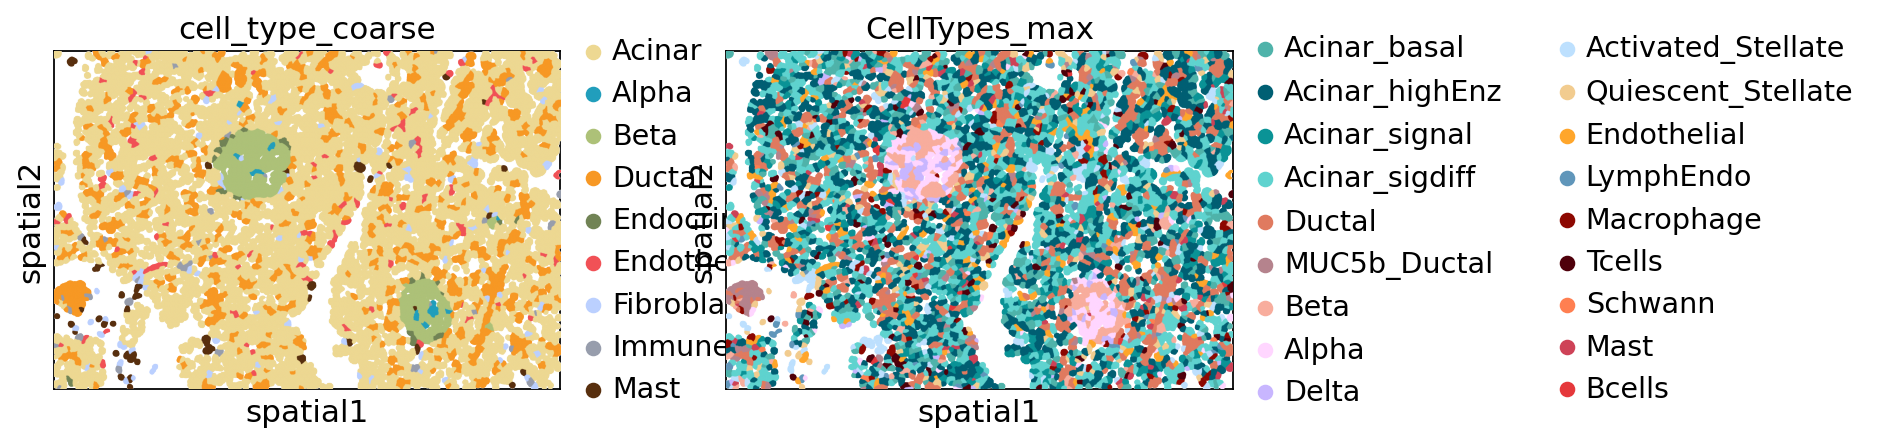

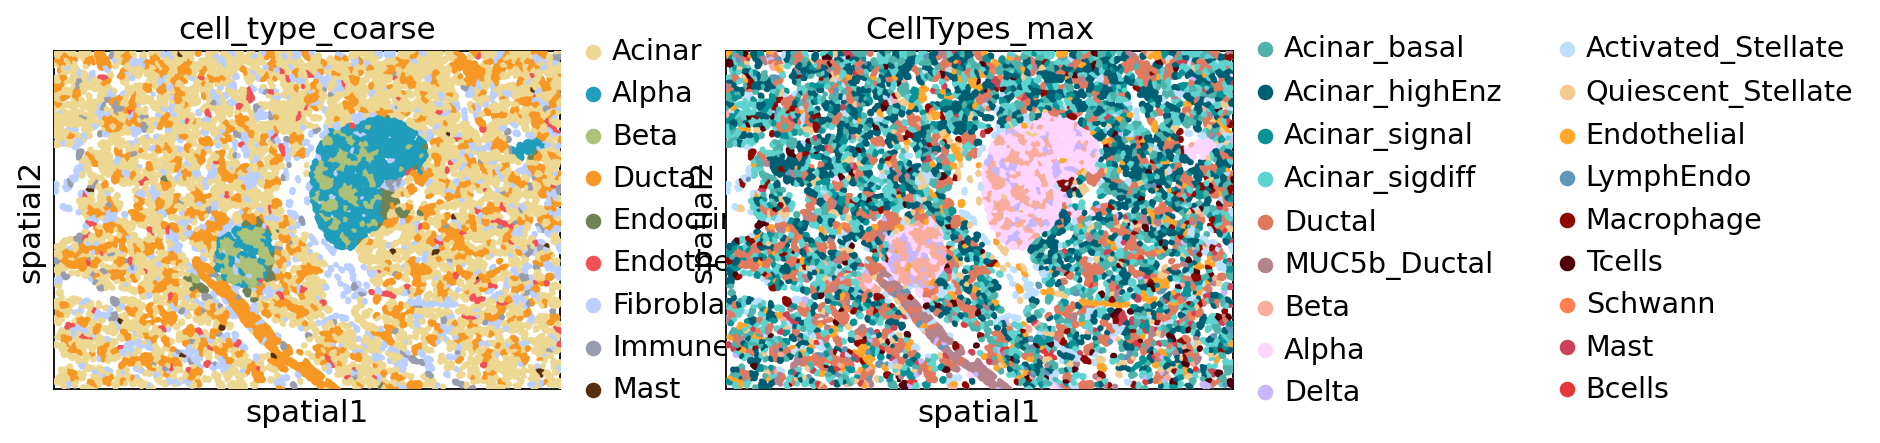

In [29]:
sq.pl.spatial_segment(adata_10,color=['cell_type_coarse','CellTypes_max'],ncols=2,library_key='fov',seg_cell_id='cell_ID',img=False)
sq.pl.spatial_segment(adata_12,color=['cell_type_coarse','CellTypes_max'],ncols=2,library_key='fov',seg_cell_id='cell_ID',img=False)

In [30]:
type(adata_10.X)

numpy.ndarray

In [17]:
adata_10.X = adata_10.X.toarray()
adata_12.X = adata_12.X.toarray()

1. Noise distribution of the dataset per cell type 
- NCEM requires gaussian distribution not negative binomial 
- Important not to overnormalized -> the 

Acinar_basal
Acinar_highEnz
Acinar_sigdiff
Acinar_signal
Activated_Stellate
Alpha
Bcells
Beta
Delta
Ductal
Endothelial
LymphEndo
MUC5b_Ductal
Macrophage
Mast
Quiescent_Stellate
Schwann
Tcells


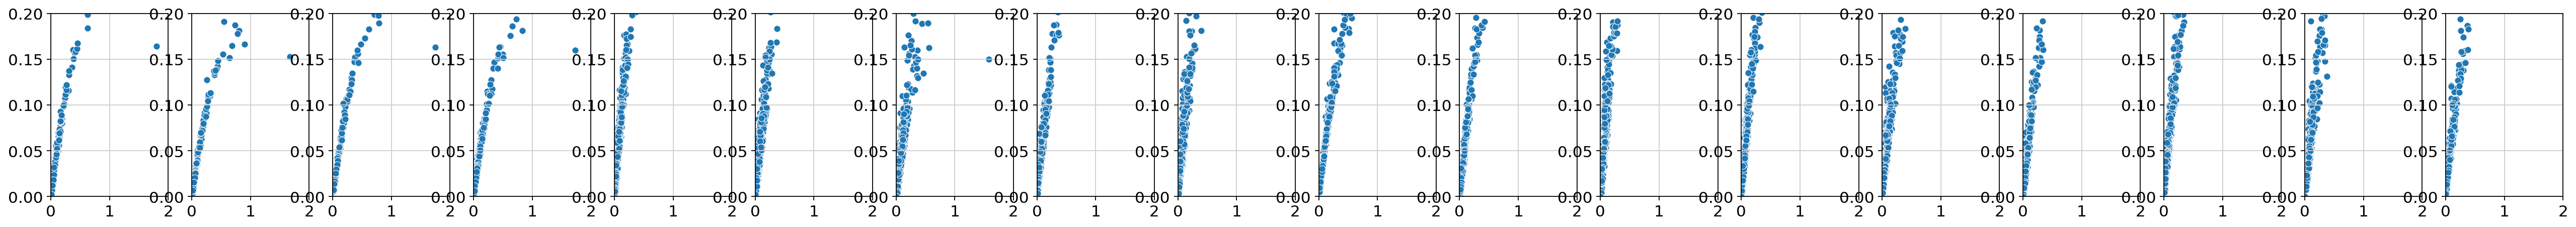

In [31]:
fig, ax = plt.subplots(1,len(np.unique(adata_10.obs['CellTypes_max'])), figsize=(40,3))
for i, ct in enumerate(np.unique(adata_10.obs['CellTypes_max'])):
    print(ct)
    mean = np.mean(adata_10[adata_10.obs['CellTypes_max']==ct].X, axis=0)
    var = np.var(adata_10[adata_10.obs['CellTypes_max']==ct].X, axis=0)
    g=sns.scatterplot(x=mean, y=var, ax=ax[i])
    g.set(ylim=(0, 0.2), xlim=(0,2))

Acinar_basal
Acinar_highEnz
Acinar_sigdiff
Acinar_signal
Activated_Stellate
Alpha
Bcells
Beta
Delta
Ductal
Endothelial
LymphEndo
MUC5b_Ductal
Macrophage
Mast
Quiescent_Stellate
Schwann
Tcells


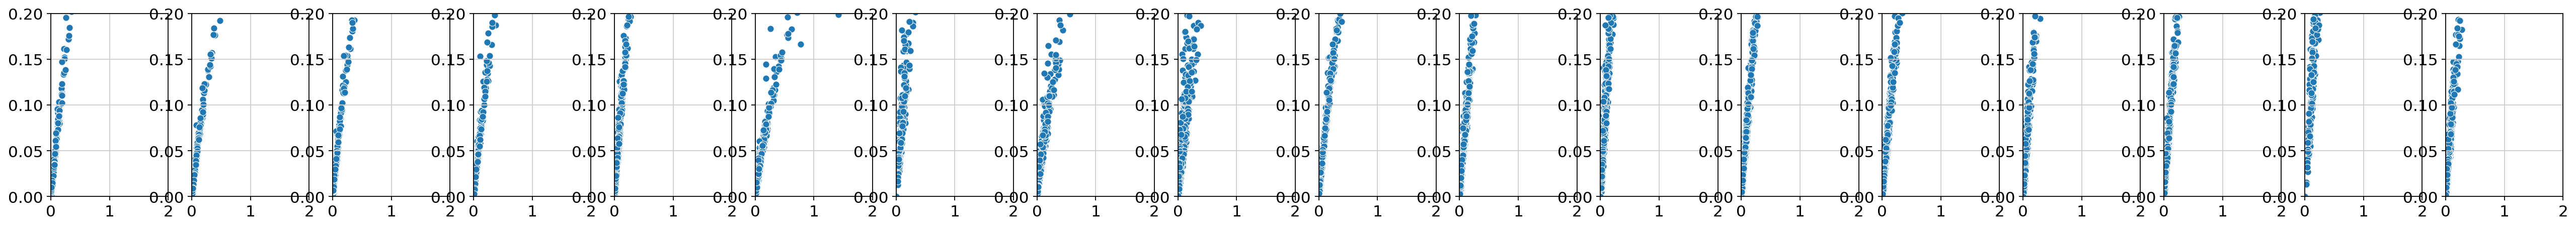

In [32]:
fig, ax = plt.subplots(1,len(np.unique(adata_12.obs['CellTypes_max'])), figsize=(40,3))
for i, ct in enumerate(np.unique(adata_12.obs['CellTypes_max'])):
    print(ct)
    mean = np.mean(adata_12[adata_12.obs['CellTypes_max']==ct].X, axis=0)
    var = np.var(adata_12[adata_12.obs['CellTypes_max']==ct].X, axis=0)
    g=sns.scatterplot(x=mean, y=var, ax=ax[i])
    g.set(ylim=(0, 0.2), xlim=(0,2))

### Pre-processing

In [20]:
adata_10.X.max(),adata_12.X.max()

(4.3824596, 4.3965755)

In [21]:
adata_10.layers['counts'].max(),adata_12.layers['counts'].max()

(226, 177)

#### the data seems normalized
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
adata.X

In [ ]:
# calculating node degree for several distances 
for rd in [0,35,50,110,180,500]:
    connectivities, _ = sq.gr.spatial_neighbors(
        adata, radius=rd, coord_type='generic', copy=True
    )
    print(np.mean(np.sum(connectivities, axis=0)))

In [33]:
sq.gr.spatial_neighbors(
    adata_10,
    n_neighs=50,
    coord_type="generic",
    delaunay=True,
    library_key='fov'
)

sq.gr.spatial_neighbors(
    adata_12,
    n_neighs=50,
    coord_type="generic",
    delaunay=True,
    library_key='fov'
)

### Neighbors enrichment analysis

In [35]:
sq.gr.nhood_enrichment(adata_10,cluster_key='CellTypes_max')
sq.gr.nhood_enrichment(adata_12,cluster_key='CellTypes_max')

100%|██████████| 1000/1000 [00:00<00:00, 1404.67/s]


/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/squidpy/pl/_utils.py:557: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row_labels = adata.obs[key][row_order]
/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/squidpy/pl/_utils.py:557: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be trea

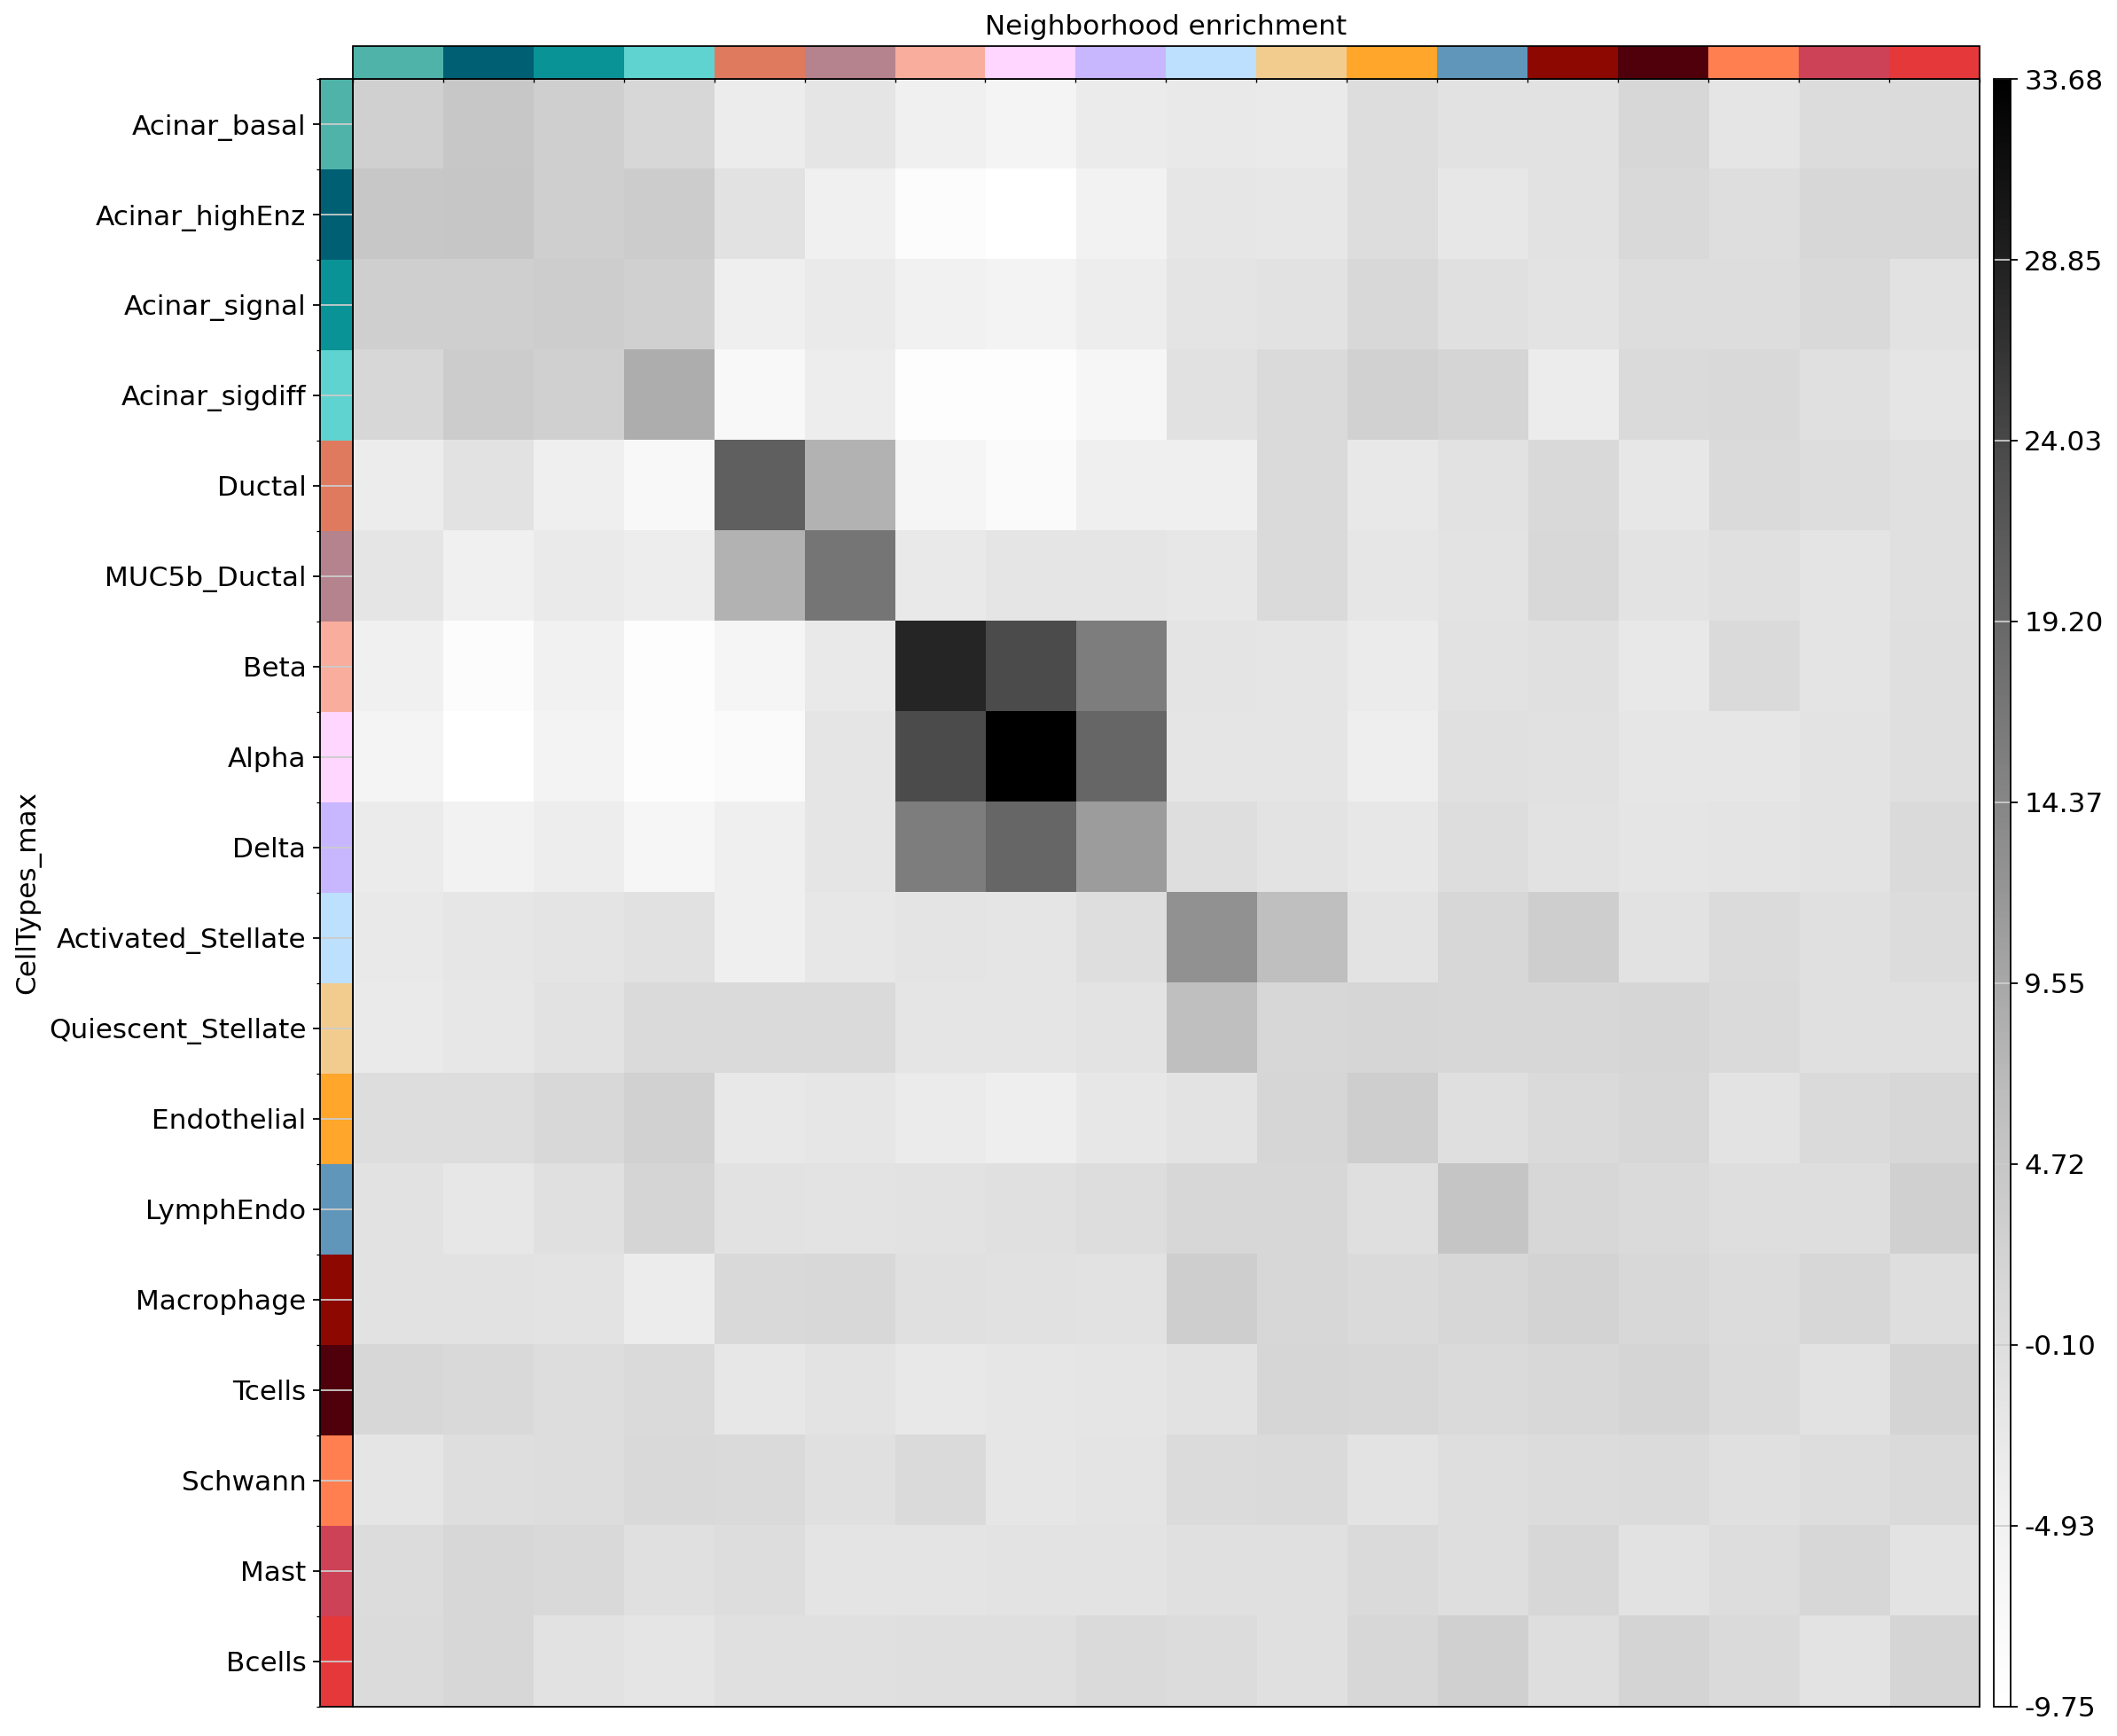

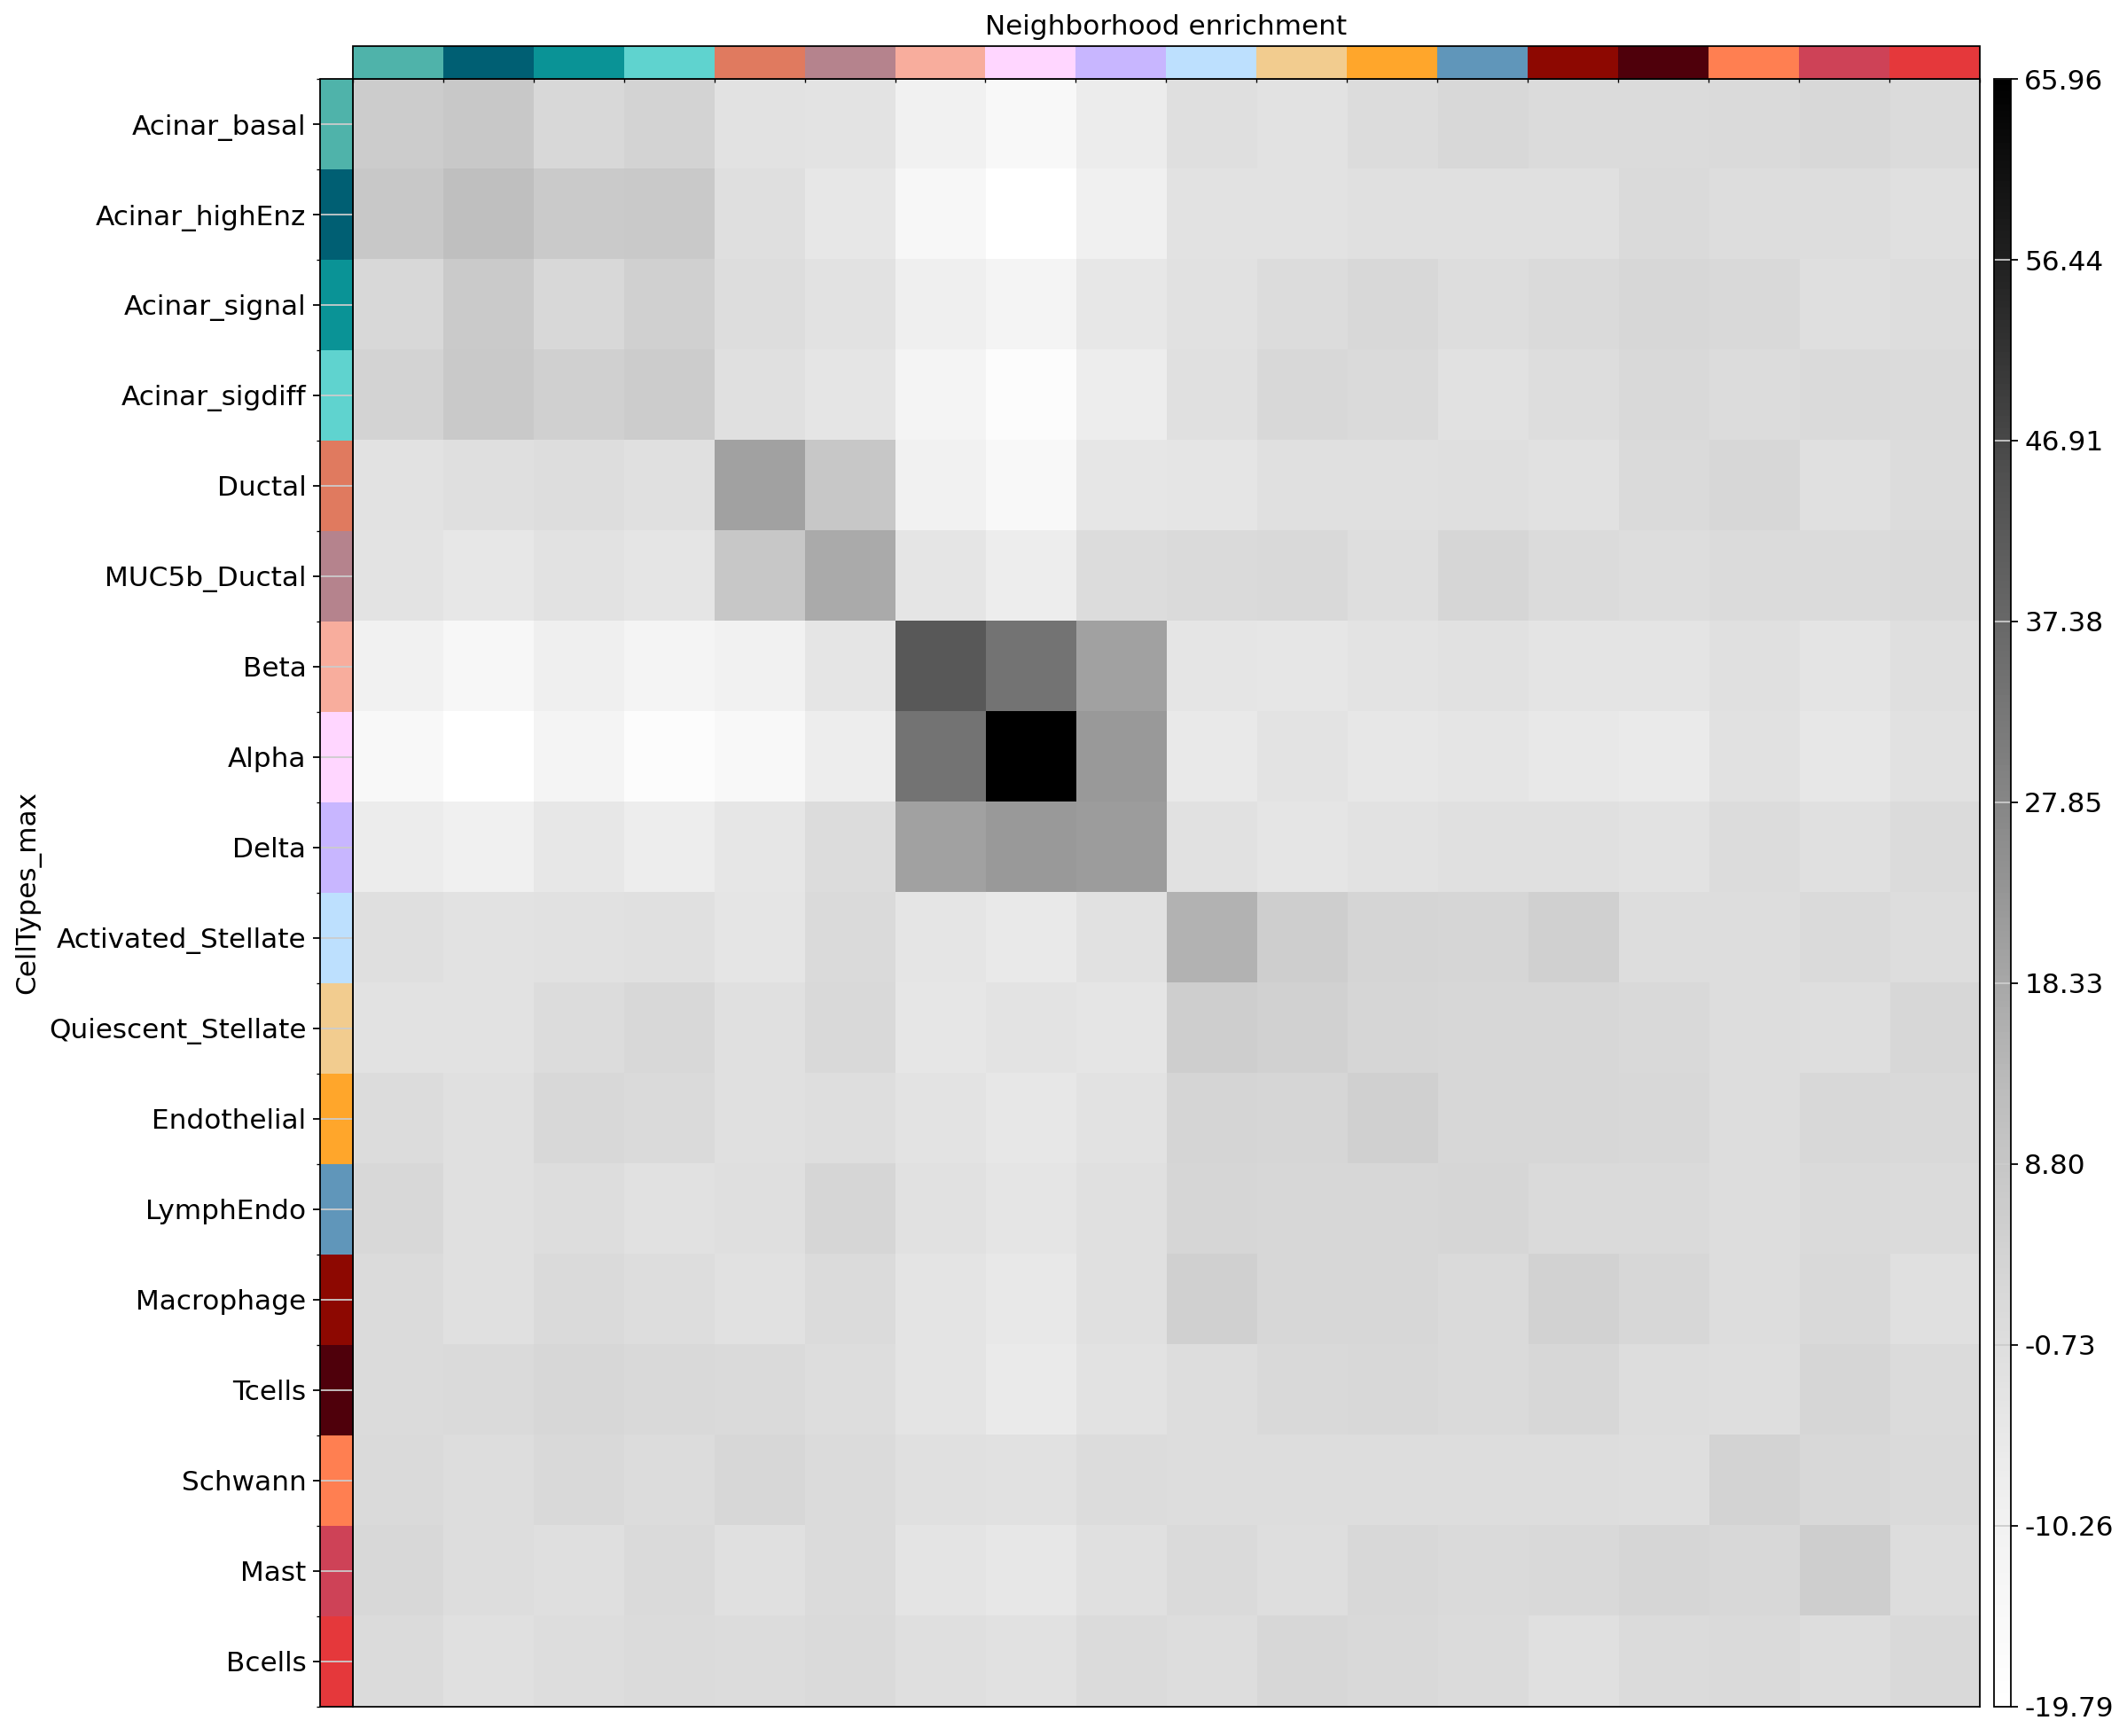

In [36]:
sq.pl.nhood_enrichment(adata_10, cluster_key='CellTypes_max',cmap='Greys')
sq.pl.nhood_enrichment(adata_12, cluster_key='CellTypes_max',cmap='Greys')

In [37]:
sq.gr.interaction_matrix(adata_10, cluster_key='CellTypes_max',weights=True)
sq.gr.interaction_matrix(adata_12, cluster_key='CellTypes_max',weights=True)

/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/squidpy/pl/_utils.py:557: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row_labels = adata.obs[key][row_order]
/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/squidpy/pl/_utils.py:557: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be trea

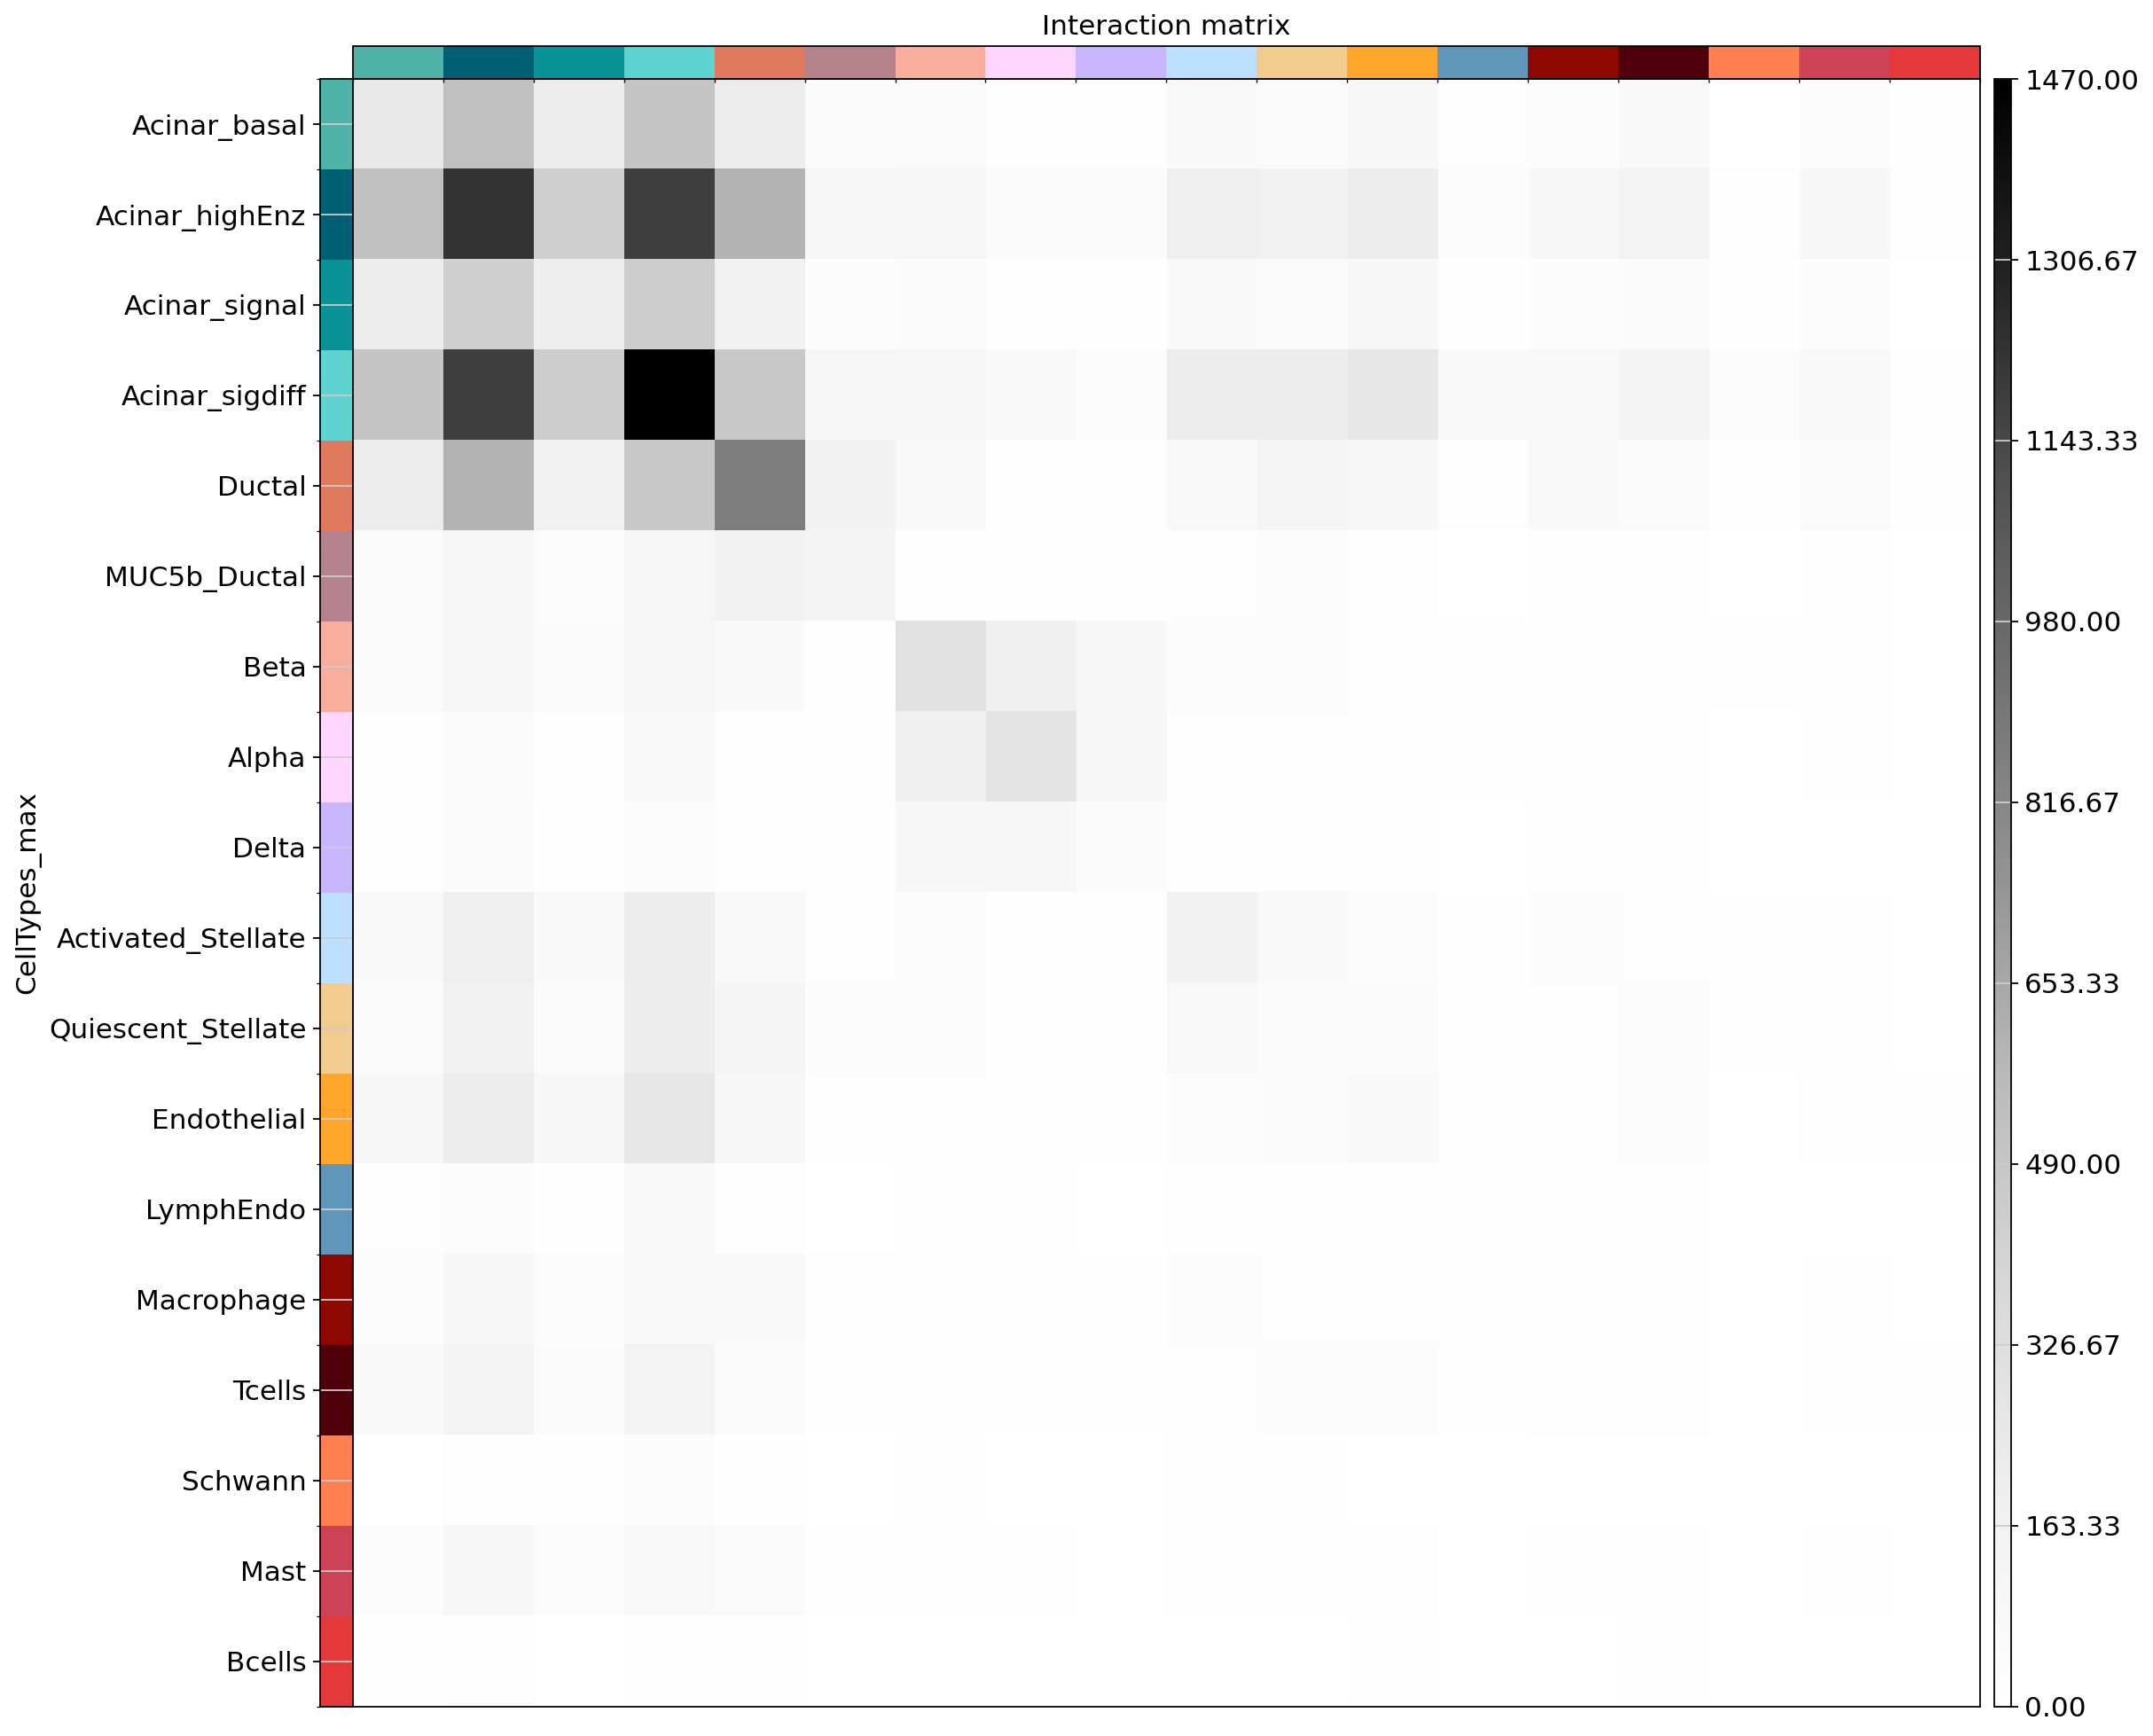

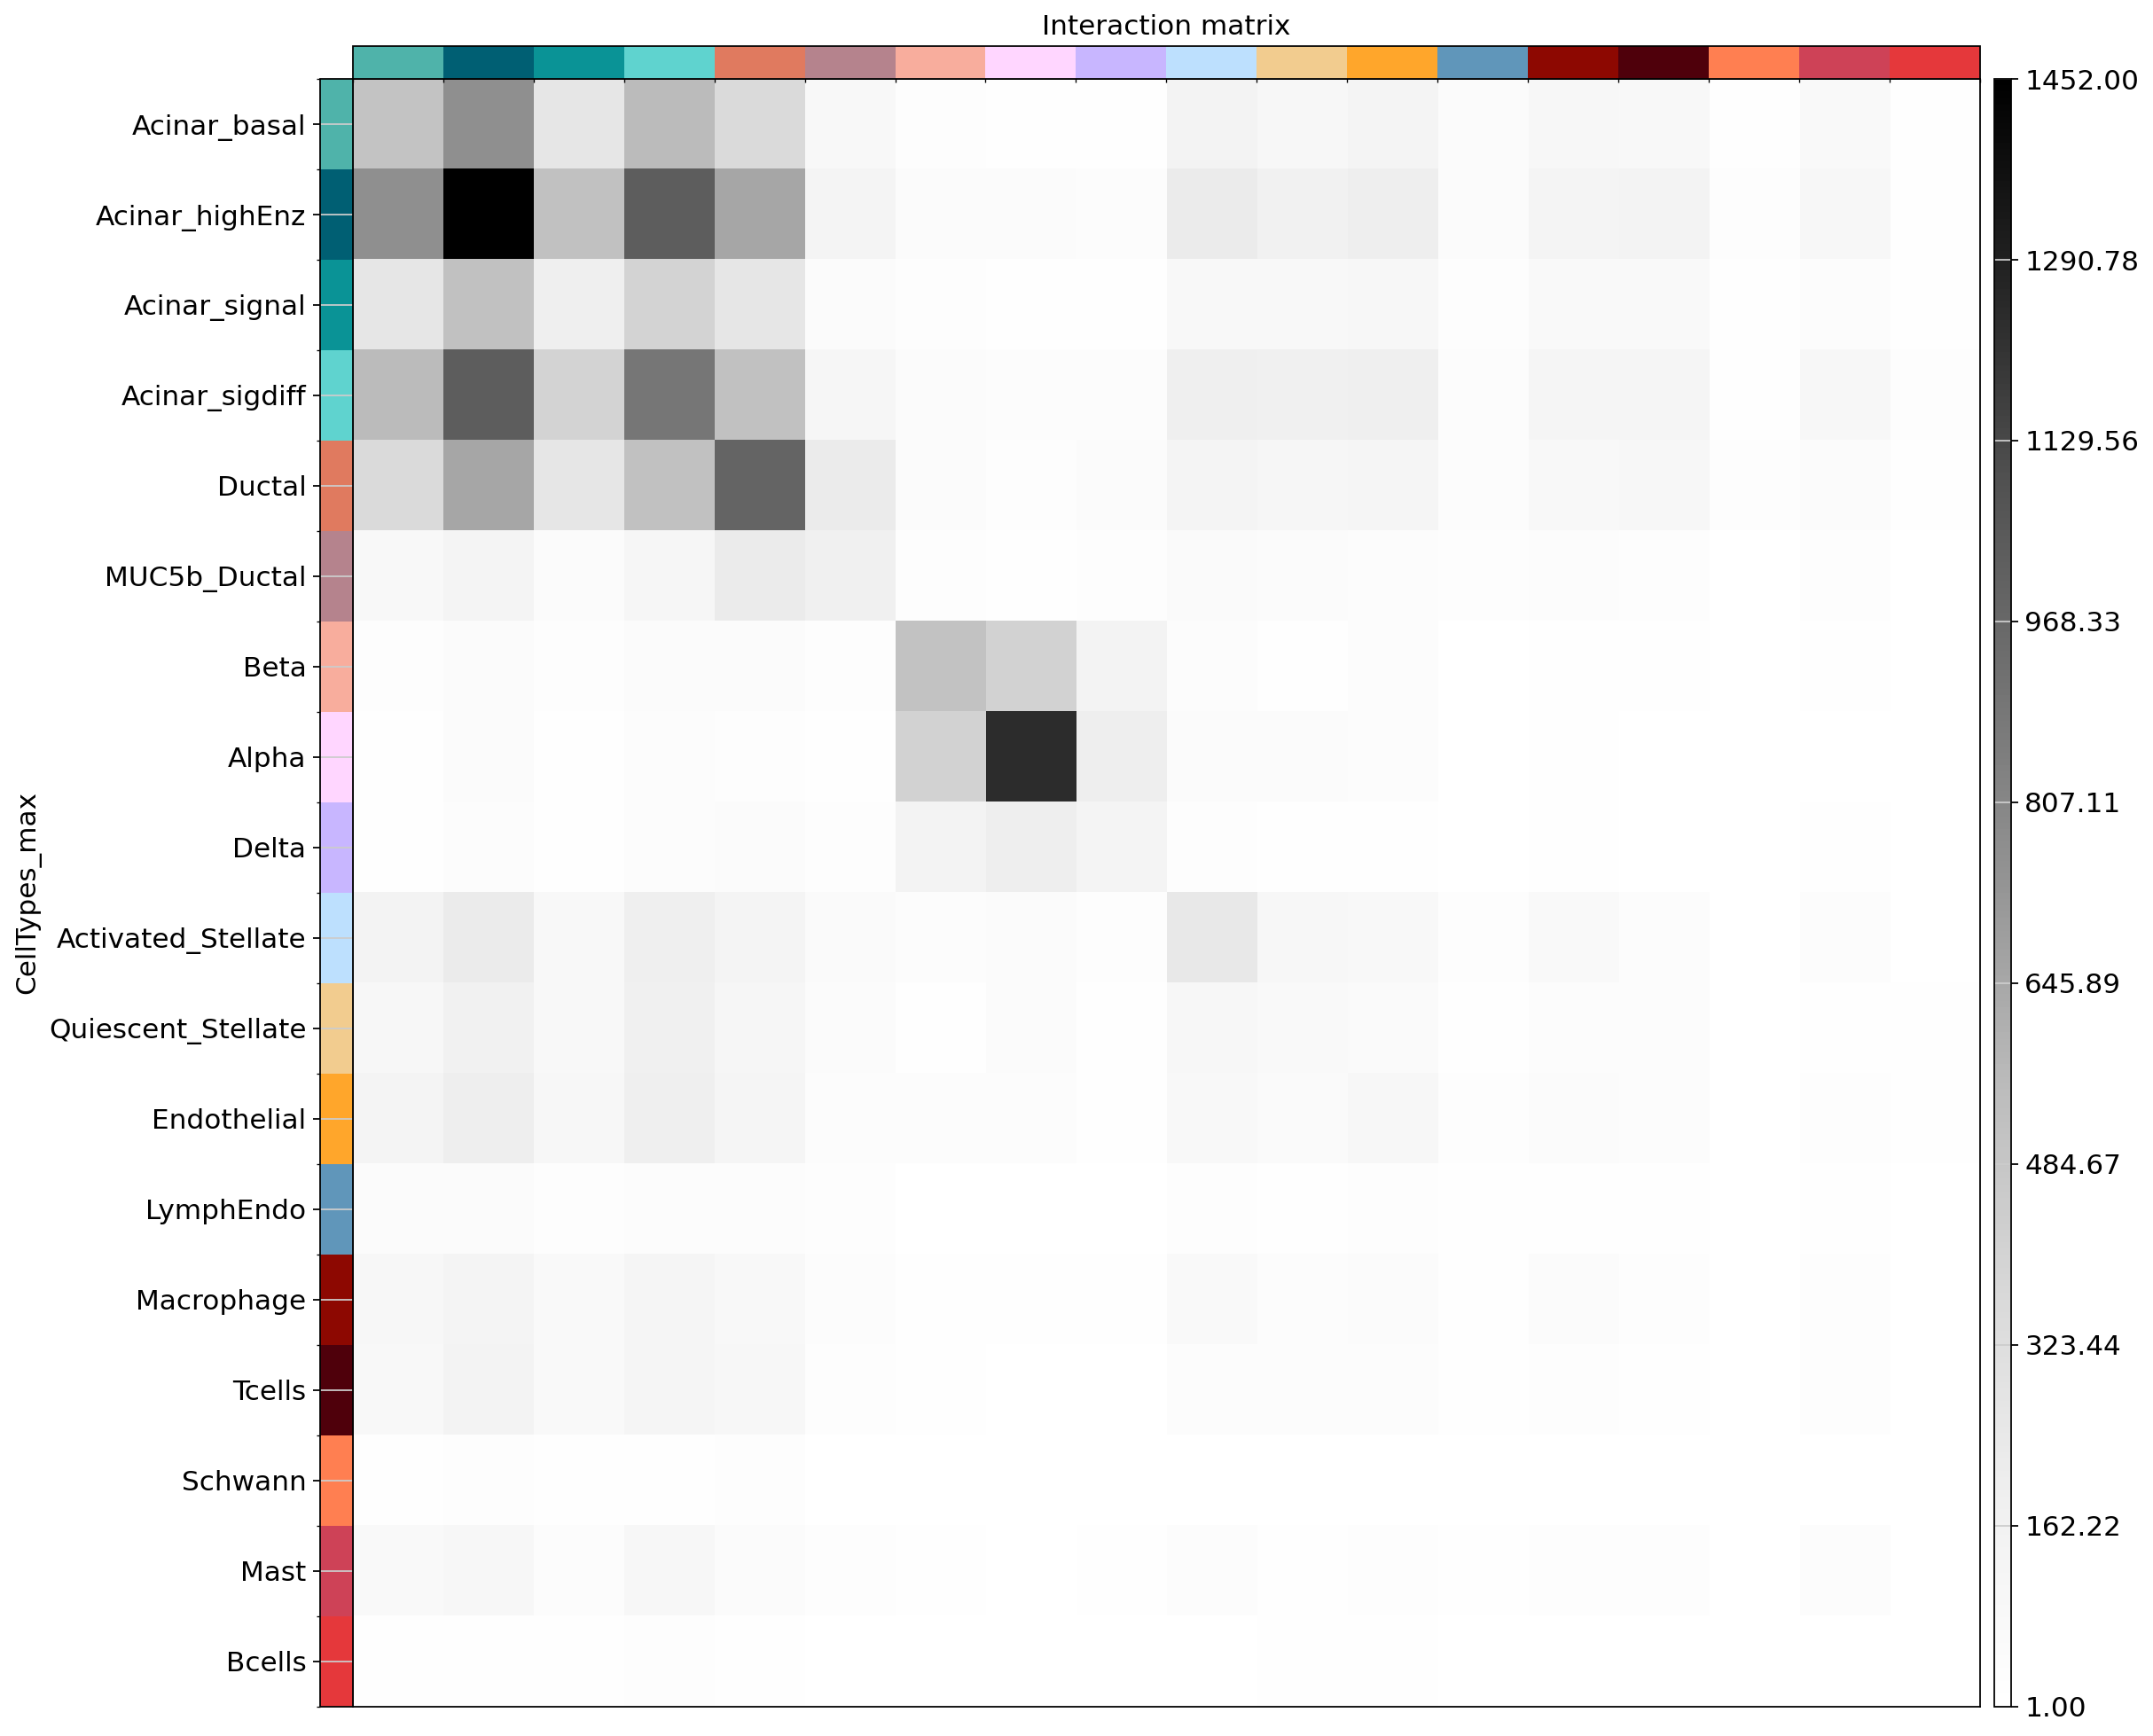

In [38]:
sq.pl.interaction_matrix(adata_10, cluster_key='CellTypes_max',cmap='Greys')
sq.pl.interaction_matrix(adata_12, cluster_key='CellTypes_max',cmap='Greys')

### Moran’s I score

The Moran’s I global spatial auto-correlation statistics evaluates whether features (i.e. genes) shows a pattern that is clustered, dispersed or random in the tissue are under consideration.

In [39]:
#sq.gr.spatial_neighbors(adata, coord_type="generic", delaunay=True)
sq.gr.spatial_autocorr(
    adata_10,
    mode="moran",
    n_perms=100,
    n_jobs=1,
)
adata_10.uns["moranI"].head(10)

100%|██████████| 100/100 [00:20<00:00,  4.89/s]


I  pval_norm  var_norm  pval_z_sim  pval_sim   var_sim  \
INS     0.760236        0.0  0.000077         0.0  0.009901  0.000152   
TTR     0.690693        0.0  0.000077         0.0  0.009901  0.000165   
GCG     0.672162        0.0  0.000077         0.0  0.009901  0.000152   
PRSS2   0.630984        0.0  0.000077         0.0  0.009901  0.000144   
CHGA    0.624503        0.0  0.000077         0.0  0.009901  0.000126   
REG1A   0.603012        0.0  0.000077         0.0  0.009901  0.000121   
CPB1    0.577031        0.0  0.000077         0.0  0.009901  0.000137   
IAPP    0.543026        0.0  0.000077         0.0  0.009901  0.000123   
SST     0.498951        0.0  0.000077         0.0  0.009901  0.000113   
SPINK1  0.458825        0.0  0.000077         0.0  0.009901  0.000131   

        pval_norm_fdr_bh  pval_z_sim_fdr_bh  pval_sim_fdr_bh  
INS                  0.0                0.0         0.038928  
TTR                  0.0                0.0         0.038928  
GCG                  0.0                0.0         0.038928  
PRSS2                0.0                0.0         0.038928  
CHGA                 0.0                0.0         0.038928  
REG1A                0.0                0.0         0.038928  
CPB1                 0.0                0.0         0.038928  
IAPP                 0.0                0.0         0.038928  
SST                  0.0                0.0         0.038928  
SPINK1               0.0                0.0         0.038928

In [40]:
#sq.gr.spatial_neighbors(adata, coord_type="generic", delaunay=True)
sq.gr.spatial_autocorr(
    adata_12,
    mode="moran",
    n_perms=100,
    n_jobs=1,
)
adata_12.uns["moranI"].head(10)

100%|██████████| 100/100 [00:22<00:00,  4.41/s]


I  pval_norm  var_norm  pval_z_sim  pval_sim   var_sim  \
TTR     0.841436        0.0  0.000065         0.0  0.009901  0.000136   
GCG     0.813863        0.0  0.000065         0.0  0.009901  0.000144   
CHGA    0.765895        0.0  0.000065         0.0  0.009901  0.000123   
INS     0.757733        0.0  0.000065         0.0  0.009901  0.000168   
PRSS2   0.732667        0.0  0.000065         0.0  0.009901  0.000131   
REG1A   0.714490        0.0  0.000065         0.0  0.009901  0.000141   
CPB1    0.674632        0.0  0.000065         0.0  0.009901  0.000147   
SPINK1  0.551265        0.0  0.000065         0.0  0.009901  0.000111   
IAPP    0.515339        0.0  0.000065         0.0  0.009901  0.000094   
SCG5    0.422968        0.0  0.000065         0.0  0.009901  0.000091   

        pval_norm_fdr_bh  pval_z_sim_fdr_bh  pval_sim_fdr_bh  
TTR                  0.0                0.0          0.02826  
GCG                  0.0                0.0          0.02826  
CHGA                 0.0                0.0          0.02826  
INS                  0.0                0.0          0.02826  
PRSS2                0.0                0.0          0.02826  
REG1A                0.0                0.0          0.02826  
CPB1                 0.0                0.0          0.02826  
SPINK1               0.0                0.0          0.02826  
IAPP                 0.0                0.0          0.02826  
SCG5                 0.0                0.0          0.02826

In [ ]:
adata.uns["moranI"].head(10).index.values

In [ ]:
adata.obs.cell_type_coarse.value_counts()

In [ ]:
sc.pl.matrixplot(adata, adata.uns["moranI"].head(10).index.values, groupby='cell_type_coarse', cmap='Greys')
#mp.add_totals().style(edge_color='black').show()

In [ ]:
sq.pl.spatial_segment(
    adata,
    library_id="10",
    seg_cell_id="cell_ID",
    library_key="fov",
    color=["GCG", "INS", "CPB1","SPINK1"],
    size=60,
    img=False,cmap="RdYlBu_r"
)

### Ligand receptor analysis

In [46]:
sq.gr.ligrec(adata_10,cluster_key='CellTypes_max',use_raw=False, alpha=0.001)
sq.gr.ligrec(adata_12,cluster_key='CellTypes_max',use_raw=False, alpha=0.001)

/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/squidpy/gr/_ligrec.py:733: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = data.groupby("clusters")
100%|██████████| 1000/1000 [00:02<00:00, 360.88permutation/s]
/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/squidpy/gr/_ligrec.py:733: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = data.groupby("clusters")
100%|██████████| 1000/1000 [00:02<00:00, 347.47permutation/s]


/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/squidpy/pl/_ligrec.py:306: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  for cls, size in (pvals.groupby(level=0, axis=1)).size().to_dict().items():
/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


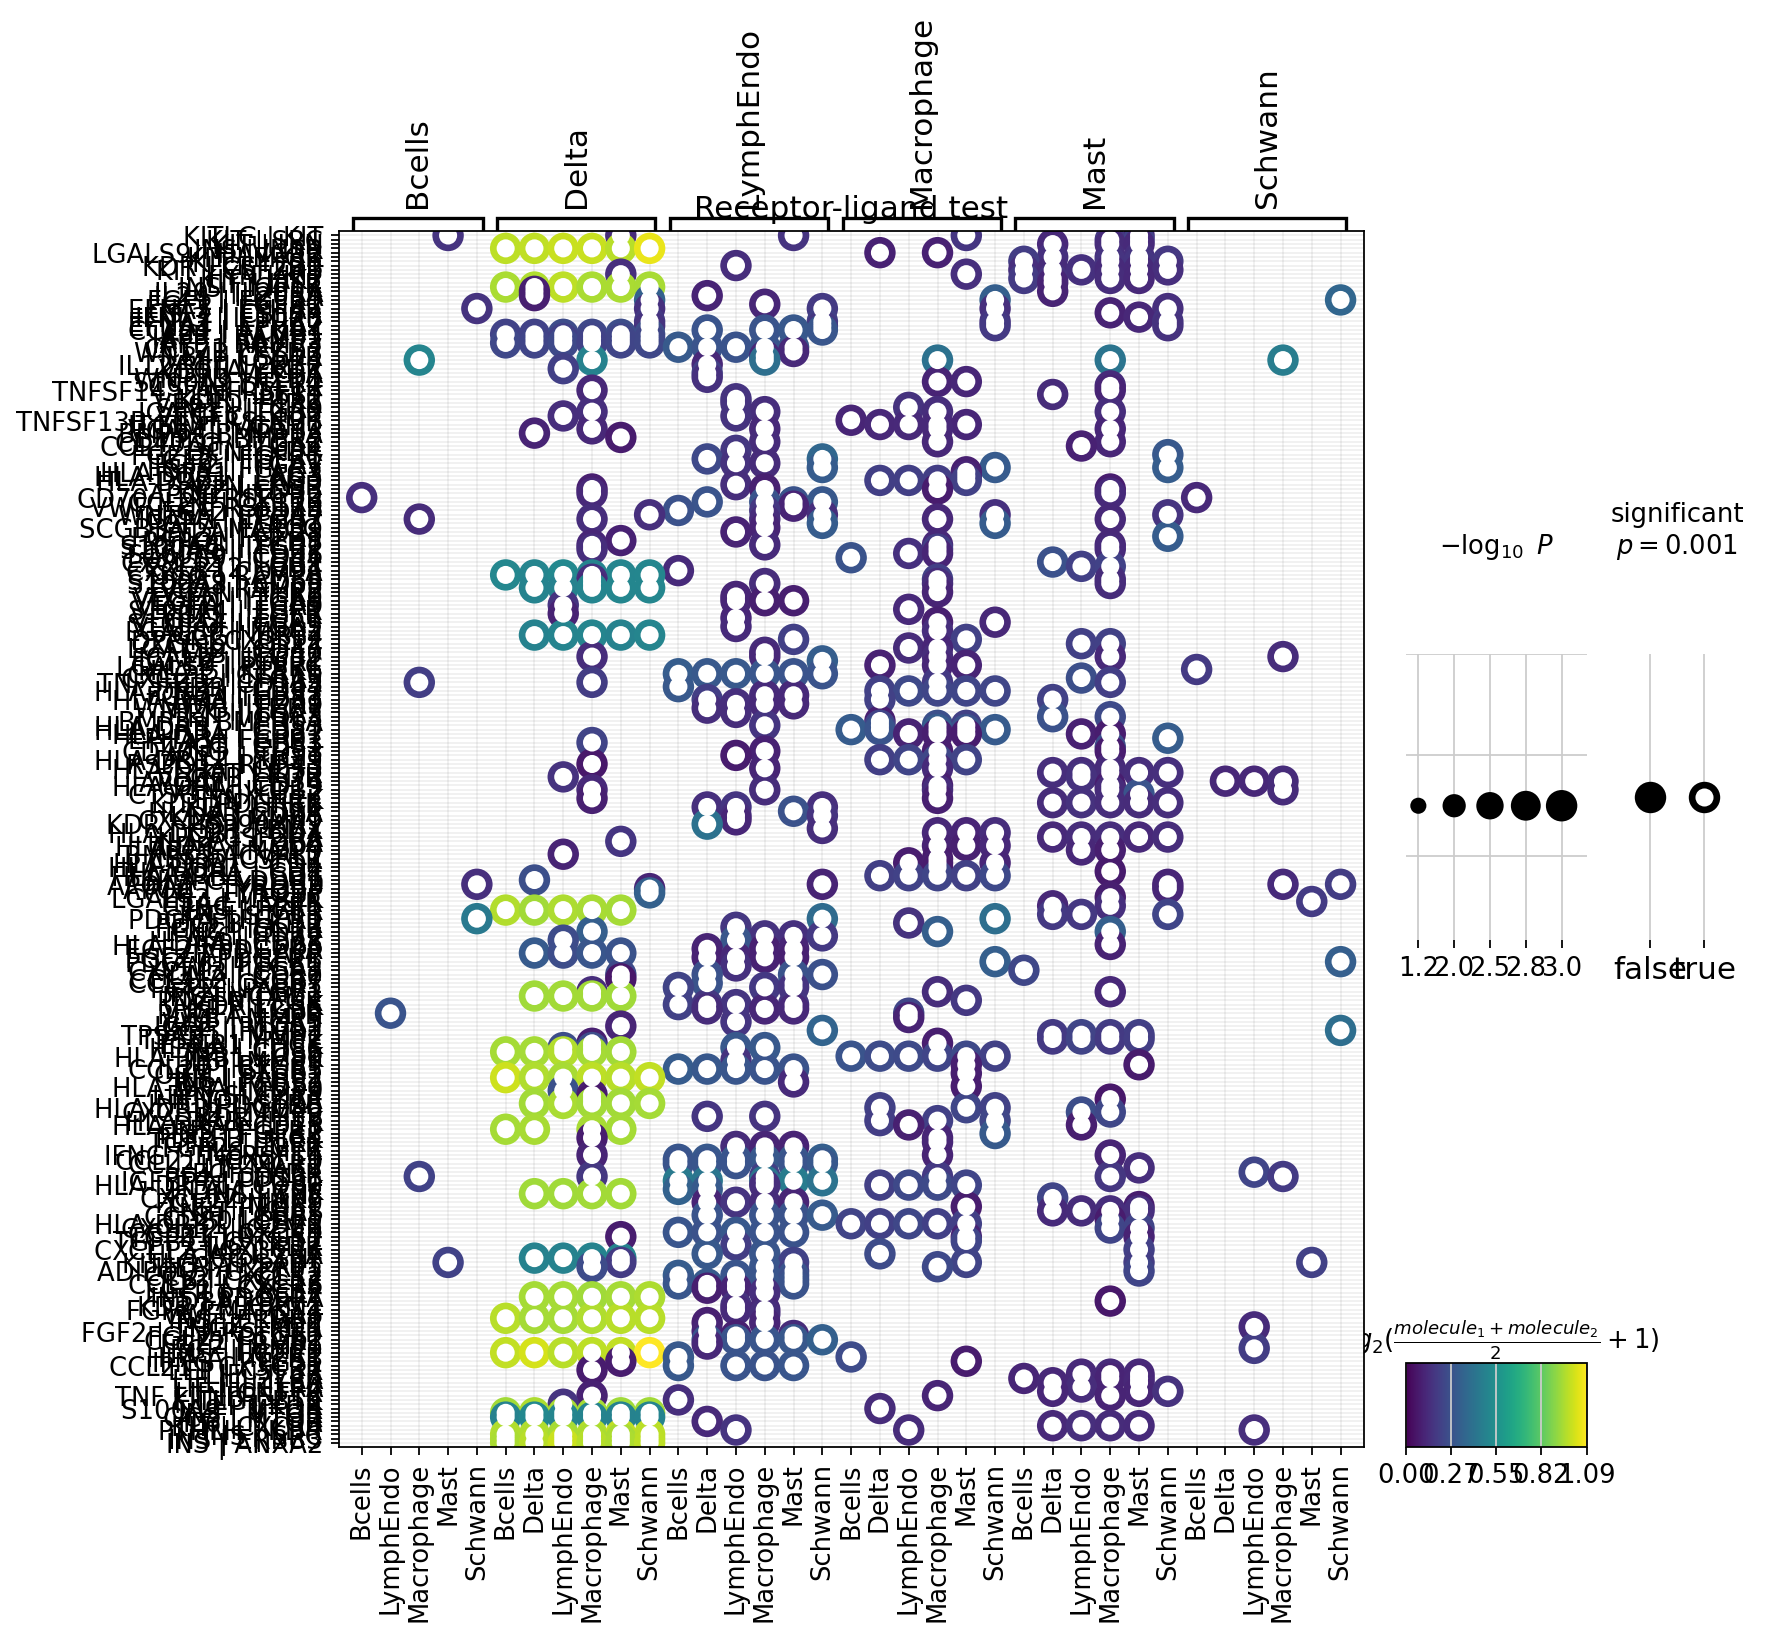

In [47]:
sq.pl.ligrec(adata_10, cluster_key='CellTypes_max',pvalue_threshold=0.0001,
             remove_nonsig_interactions=True, remove_empty_interactions=True,figsize = (10,10))

/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/squidpy/pl/_ligrec.py:306: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  for cls, size in (pvals.groupby(level=0, axis=1)).size().to_dict().items():
/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


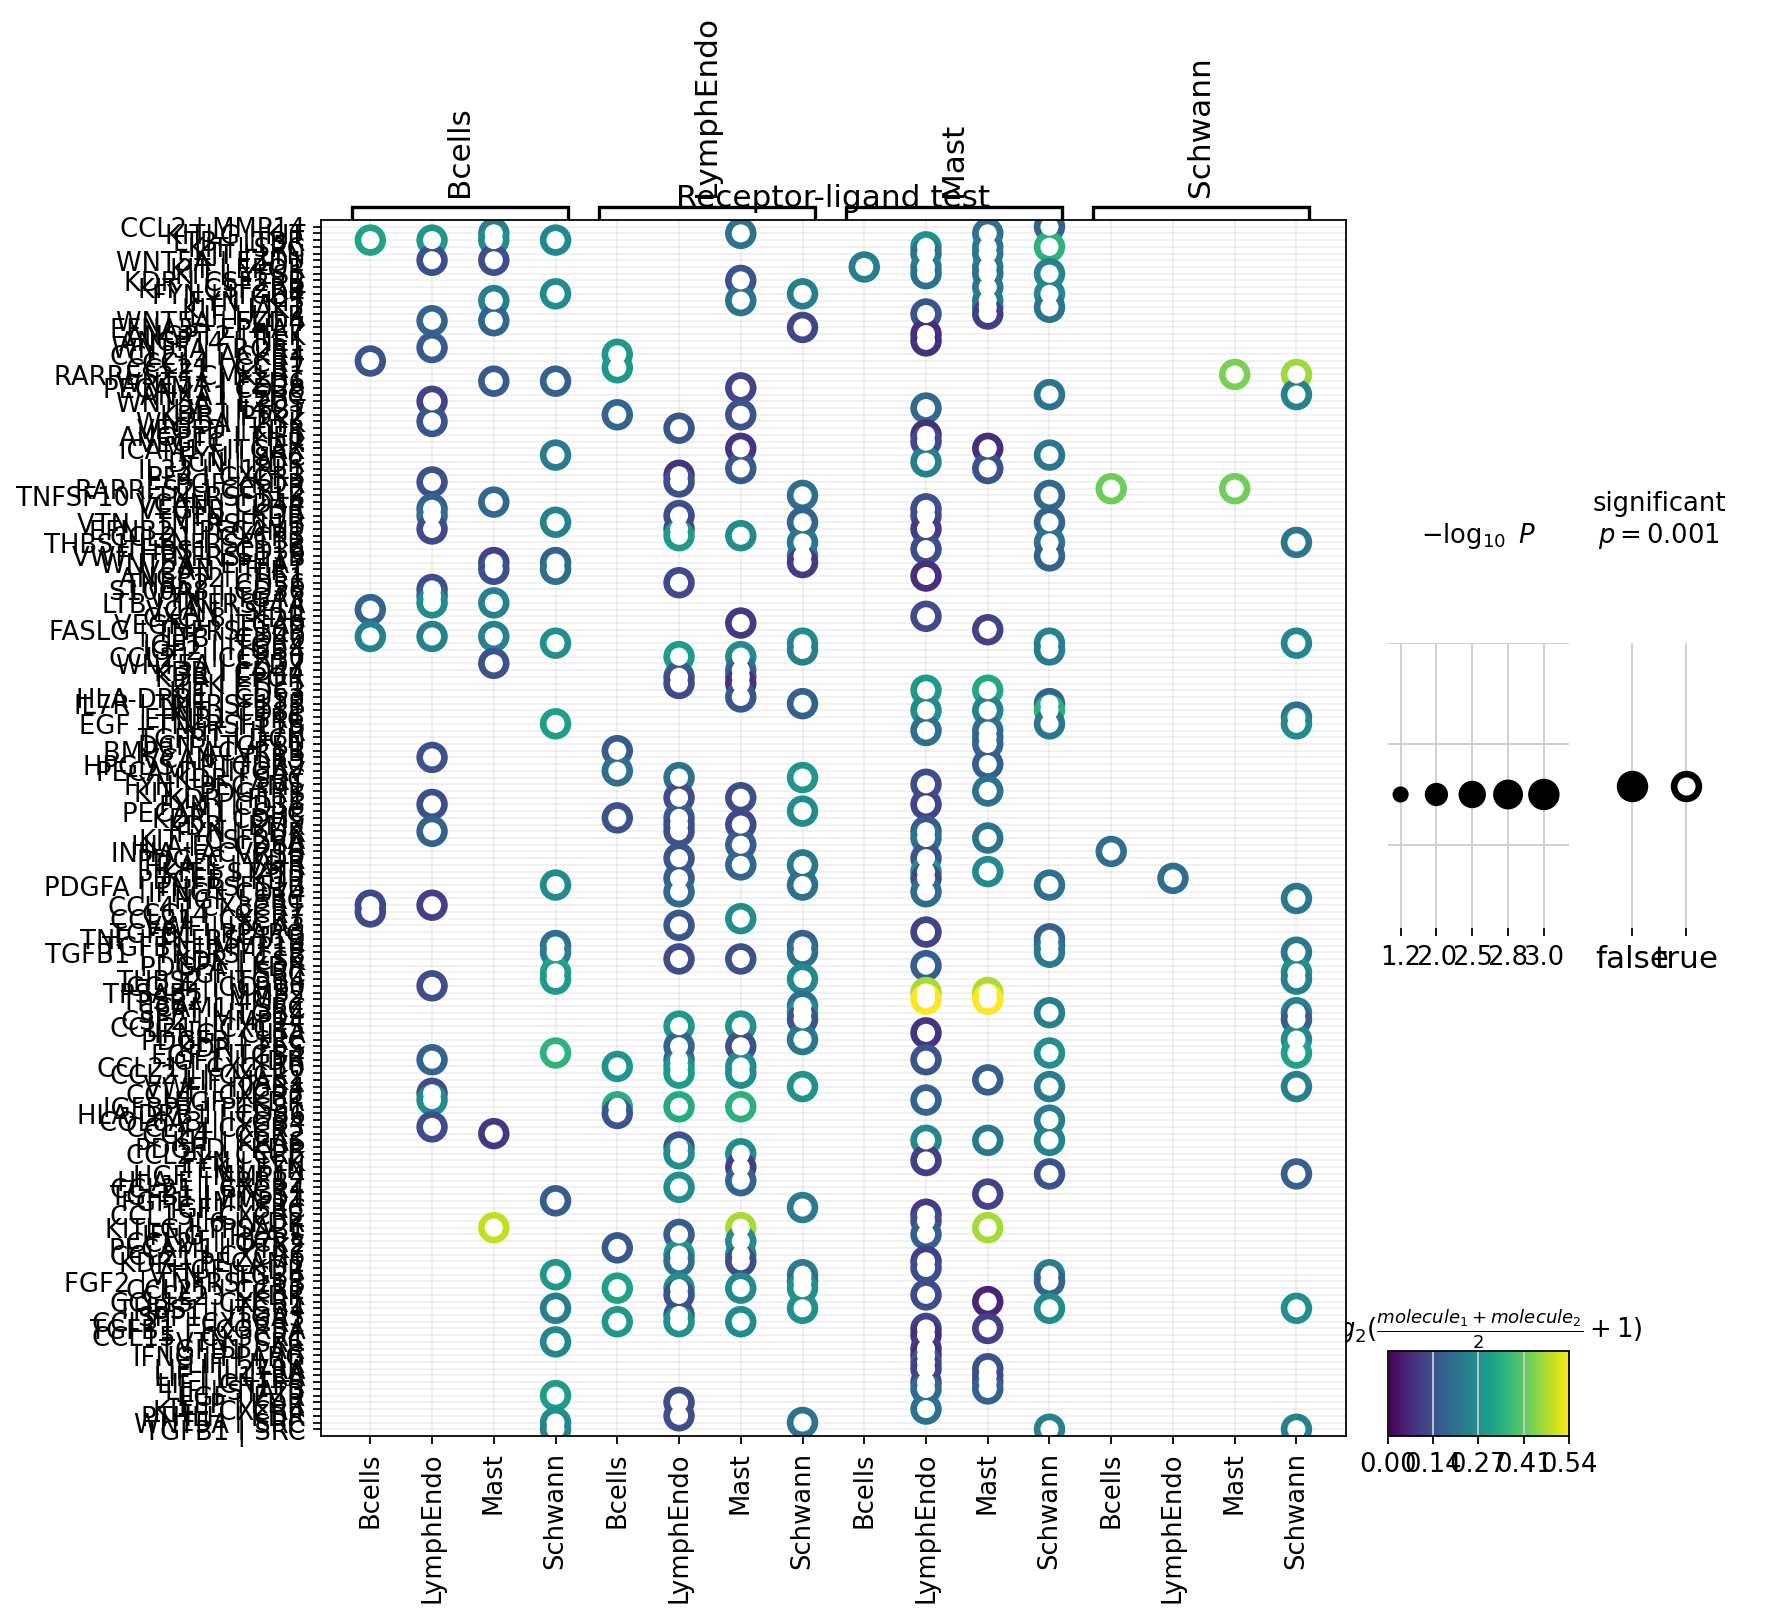

In [44]:
sq.pl.ligrec(adata_12, cluster_key='CellTypes_max',pvalue_threshold=0.0001,
             remove_nonsig_interactions=True, remove_empty_interactions=True,figsize = (10,10))

### NCEM

In [41]:
from ncem.tl.fit.glm import linear_ncem

In [48]:
adata_10 = linear_ncem(adata=adata_10, key_type='CellTypes_max', key_graph='spatial_connectivities')
adata_12 = linear_ncem(adata=adata_12, key_type='CellTypes_max', key_graph='spatial_connectivities')

/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [61]:
adata_12.obs['CellTypes_max'].value_counts()

CellTypes_max
Acinar_highEnz        940
Acinar_sigdiff        765
Ductal                627
Acinar_basal          544
Acinar_signal         369
Alpha                 361
Activated_Stellate    243
Beta                  234
Endothelial           199
Quiescent_Stellate    182
MUC5b_Ductal          181
Macrophage            138
Delta                 121
Tcells                119
Mast                   90
LymphEndo              53
Bcells                 22
Schwann                20
Name: count, dtype: int64

In [62]:
adata_10.obs['CellTypes_max'].value_counts()

CellTypes_max
Acinar_sigdiff        913
Acinar_highEnz        879
Ductal                520
Acinar_basal          376
Acinar_signal         323
Beta                  188
Activated_Stellate    182
Endothelial           178
Quiescent_Stellate    161
Alpha                 143
MUC5b_Ductal          124
Tcells                113
Macrophage             92
Delta                  75
Mast                   73
LymphEndo              45
Schwann                20
Bcells                 18
Name: count, dtype: int64

In [49]:
adata_10, adata_12

(AnnData object with n_obs × n_vars = 4423 × 979
     obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.GCG', 'Max.GCG', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'condition', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_NegPrb', 'log1p_total_counts_NegPrb', 'pct_counts_NegPrb', 'n_genes', 'cell_type_coarse', 'CellTypes_max'
     var: 'NegPrb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
     uns: 'CellTypes_max_colors', 'cell_type_coarse_colors', 'log1p', 'neighbors', 'pca', 'spatial', 'umap', 'spatial_neighbors', 'CellTypes_max_nhood_enrichment', 'CellTypes_max_interactions', 'mo

#### Exploring interesting interactions

In [50]:
adata_10.varm['ncem_params']

index_Acinar_basal  index_Acinar_highEnz  index_Acinar_sigdiff  \
AATK                0.086326              0.053575              0.075350   
ABL1                0.022724              0.009091              0.037609   
ABL2                0.204781              0.120916              0.181640   
ACE                -0.030963             -0.010399              0.015837   
ACE2               -0.004580              0.012444              0.016854   
...                      ...                   ...                   ...   
NegPrb19            0.014963              0.015706             -0.002721   
NegPrb20           -0.005702              0.045603              0.059917   
NegPrb21            0.031753              0.015385              0.012400   
NegPrb22           -0.026958              0.028317              0.007071   
NegPrb23            0.011132              0.009454              0.007765   

          index_Acinar_signal  index_Activated_Stellate  index_Alpha  \
AATK                 0.041750                  0.046486    -0.013063   
ABL1                 0.045911                  0.017501     0.088935   
ABL2                 0.275306                  0.152180     0.097117   
ACE                  0.053508                  0.016393    -0.070351   
ACE2                -0.001710                  0.027399     0.017721   
...                       ...                       ...          ...   
NegPrb19             0.010441                  0.013378     0.016997   
NegPrb20             0.116902                  0.075877    -0.052136   
NegPrb21            -0.016697                  0.021318    -0.011704   
NegPrb22             0.011686                  0.020291     0.002425   
NegPrb23             0.019757                  0.003491     0.097340   

          index_Bcells  index_Beta   index_Delta  index_Ductal  ...  \
AATK     -3.341559e-14    0.094259 -9.848403e-02      0.026019  ...   
ABL1      4.561269e-14    0.105148  1.570187e-01      0.095307  ...   
ABL2      4.376134e-01    0.152345 -3.770303e-02      0.101769  ...   
ACE       5.323972e-14    0.095028  9.241267e-02      0.006793  ...   
ACE2      1.227403e-01    0.040652  3.703520e-02      0.025479  ...   
...                ...         ...           ...           ...  ...   
NegPrb19  6.049741e-16    0.010946  1.830970e-15      0.020438  ...   
NegPrb20  2.329067e-01   -0.015874  2.192170e-02      0.033455  ...   
NegPrb21  1.227403e-01    0.002019  6.056057e-02      0.005720  ...   
NegPrb22 -5.936297e-02    0.027631  1.651031e-03      0.017194  ...   
NegPrb23 -4.021060e-14   -0.075600  6.290400e-02      0.033106  ...   

          index_Delta:neighbor_Tcells  index_Ductal:neighbor_Tcells  \
AATK                    -5.880341e-02                      0.008108   
ABL1                    -3.852068e-02                     -0.046454   
ABL2                    -1.589679e-01                      0.050257   
ACE                     -2.758564e-02                      0.014281   
ACE2                     1.105813e-02                     -0.003868   
...                               ...                           ...   
NegPrb19                 5.109463e-16                     -0.013943   
NegPrb20                -2.217760e-02                      0.017732   
NegPrb21                 2.435119e-02                     -0.012253   
NegPrb22                -2.511207e-03                     -0.008106   
NegPrb23                -7.457567e-03                     -0.012525   

          index_Endothelial:neighbor_Tcells  index_LymphEndo:neighbor_Tcells  \
AATK                              -0.008574                     4.113595e-02   
ABL1                              -0.012053                    -3.590735e-15   
ABL2                              -0.047586                    -6.534595e-02   
ACE                                0.031412                     4.412859e-02   
ACE2                              -0.001093                    -1.054830e-01   
...                                     ...   

In [51]:
df = pd.DataFrame(np.sum(np.absolute(adata_10.varm['ncem_params'])))
df_int_10 = pd.DataFrame(columns=adata_10.obs['CellTypes_max'].cat.categories, index=adata_10.obs['CellTypes_max'].cat.categories,dtype=float)
for s in adata_10.obs['CellTypes_max'].cat.categories:
    for r in adata_10.obs['CellTypes_max'].cat.categories: 
        index_value = 'index_'+s+':neighbor_'+r
        df_int_10.at[s,r] = df.loc[index_value][0]
df_int_10

/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Acinar_basal  Acinar_highEnz  Acinar_sigdiff  \
Acinar_basal           11.157730       14.011405       12.530273   
Acinar_highEnz          7.272206        8.820488        8.660620   
Acinar_sigdiff          7.771267        7.848163        9.680858   
Acinar_signal          11.317145       13.946856       14.713847   
Activated_Stellate     25.018695       26.705649       26.271602   
Alpha                  40.883702       33.820914       38.203357   
Bcells                 90.379095      132.556857      133.154373   
Beta                   30.549586       31.002696       31.040623   
Delta                  46.914947       56.792875       47.766474   
Ductal                 15.764697       15.435420       15.410293   
Endothelial            22.783052       23.818402       26.536004   
LymphEndo              60.426110       59.256682       56.798221   
MUC5b_Ductal           33.107618       33.263987       38.351542   
Macrophage             35.849080       32.193907       39.932237   
Mast                   35.148649       39.889296       38.461320   
Quiescent_Stellate     29.413976       26.159831       27.997673   
Schwann               130.320571      153.852837      258.250025   
Tcells                 24.983678       29.051289       31.760227   

                    Acinar_signal  Activated_Stellate         Alpha  \
Acinar_basal            12.088565           15.318112  2.701327e+01   
Acinar_highEnz           7.574891            9.011819  1.461941e+01   
Acinar_sigdiff           7.246443            9.019619  1.417070e+01   
Acinar_signal           11.547047           15.453910  2.511490e+01   
Activated_Stellate      27.093926           27.924994  4.605132e+01   
Alpha                   48.638459           36.641368  4.781804e+01   
Bcells                 126.936371          258.924695  1.049341e+02   
Beta                    30.676406           31.331957  2.743613e+01   
Delta                   50.702332           48.501921  4.374234e+01   
Ductal                  14.176532           19.258888  3.077147e+01   
Endothelial             21.000590           32.859550  4.733835e+01   
LymphEndo               59.308662           55.559983  8.454234e+01   
MUC5b_Ductal            34.433417           47.447739  4.934001e+01   
Macrophage              37.280950           38.131344  5.056722e+01   
Mast                    33.723484           46.681161  5.547171e+01   
Quiescent_Stellate      24.639008           26.691155  5.068735e+01   
Schwann                107.231217          100.298723  2.572044e-11   
Tcells                  27.516320           33.134873  4.466866e+01   

                          Bcells        Beta         Delta      Ductal  \
Acinar_basal        3.550702e+01   16.637814  2.506492e+01   11.531767   
Acinar_highEnz      2.028851e+01   12.076902  1.615701e+01    7.517925   
Acinar_sigdiff      2.918488e+01   11.147286  1.799031e+01    7.425495   
Acinar_signal       4.836540e+01   18.201436  3.011590e+01   12.086295   
Activated_Stellate  6.500803e+01   33.146705  4.599957e+01   27.435913   
Alpha               1.090696e+02   35.980846  2.481567e+01   39.438808   
Bcells              1.415482e+02  176.280984  2.540398e+02  157.098618   
Beta                6.292283e+01   32.511736  2.534694e+01   27.498317   
Delta               7.912959e+01   48.084037  4.002440e+01   45.936505   
Ductal              4.163197e+01   20.752532  3.068160e+01   16.859971   
Endothelial         5.345248e+01   35.638056  4.882270e+01   22.734131   
LymphEndo           1.025143e+02   66.551240  7.011128e+01   60.878815   
MUC5b_Ductal        8.091332e+01   47.219103  6.694772e+01   36.602612   
Macrophage          9.583160e+01   41.040819  7.185432e+01   33.153199   
Mast                1.390092e-11   48.500096  9.097098e+01   35.834255   
Quiescent_Stellate  6.813685e+01   39.752070  4.852912e+01   27.168948   
Schwann             2.993859e+02  159.583679  4.042608e-11   76.109698   
Tcells              4.810042e+01   41.962927 

In [52]:
df = pd.DataFrame(np.sum(np.absolute(adata_12.varm['ncem_params'])))
df_int_12 = pd.DataFrame(columns=adata_12.obs['CellTypes_max'].cat.categories, index=adata_12.obs['CellTypes_max'].cat.categories,dtype=float)
for s in adata_12.obs['CellTypes_max'].cat.categories:
    for r in adata_12.obs['CellTypes_max'].cat.categories: 
        index_value = 'index_'+s+':neighbor_'+r
        df_int_12.at[s,r] = df.loc[index_value][0]
df_int_12

/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Acinar_basal  Acinar_highEnz  Acinar_sigdiff  \
Acinar_basal           10.141242       12.195564       10.580320   
Acinar_highEnz          7.509122        9.514015        7.451702   
Acinar_sigdiff          8.707649        9.648175        9.088639   
Acinar_signal          12.324277       14.676164       13.427746   
Activated_Stellate     22.964474       22.081103       24.374862   
Alpha                  49.477822       26.422850       27.380169   
Bcells                143.624650       76.567373      174.476478   
Beta                   41.777559       36.470291       47.416036   
Delta                  56.459593       53.177372       45.789829   
Ductal                 13.525136       15.056666       13.791532   
Endothelial            24.831677       24.848793       22.476029   
LymphEndo              50.544672       46.560693       49.013003   
MUC5b_Ductal           28.280070       30.254736       30.212662   
Macrophage             26.745408       31.223919       29.089390   
Mast                   31.896372       32.796182       35.639344   
Quiescent_Stellate     25.085312       26.574050       28.101446   
Schwann               232.389957       96.193042       82.498048   
Tcells                 24.650228       28.952554       28.186756   

                    Acinar_signal  Activated_Stellate       Alpha      Bcells  \
Acinar_basal             9.616007           12.088603   30.582916   29.111973   
Acinar_highEnz           7.146245            9.059844   18.569621   29.651092   
Acinar_sigdiff           8.812250           10.764754   23.401385   22.850706   
Acinar_signal           12.807040           14.810210   33.462732   37.586784   
Activated_Stellate      23.845221           25.563449   40.966837   62.463689   
Alpha                   39.820496           23.906682   41.098079   57.051911   
Bcells                 170.308669          103.554079  144.152444   73.053524   
Beta                    45.911476           32.144370   27.482701   83.553088   
Delta                   49.151610           46.145889   49.656411   92.607230   
Ductal                  13.616032           15.490712   31.121370   38.780576   
Endothelial             21.517254           24.780174   48.407120   52.564653   
LymphEndo               52.106598           48.227446   85.181168   94.842907   
MUC5b_Ductal            31.351632           28.248210   49.405212   61.619619   
Macrophage              27.963347           34.662380   66.857440  140.677699   
Mast                    33.606412           36.549472   54.509156   64.302304   
Quiescent_Stellate      26.707068           24.153618   42.654766   48.914090   
Schwann                 98.126703          233.393205  131.802977  176.067629   
Tcells                  27.269010           34.037819   66.411408   57.786364   

                          Beta      Delta      Ductal  Endothelial  \
Acinar_basal         23.343800  27.888339    9.817196    11.543847   
Acinar_highEnz       16.842854  18.294307    7.167778     8.829659   
Acinar_sigdiff       18.118755  23.420194    8.381062     9.824443   
Acinar_signal        27.726166  28.917745   12.090478    14.786933   
Activated_Stellate   33.105842  41.203052   24.929858    24.481015   
Alpha                16.032093  13.083216   40.727002    20.628255   
Bcells              139.130551  98.538268   91.144112   117.480073   
Beta                 35.086273  19.434126   37.026853    35.413541   
Delta                30.468554  41.008621   56.633447    39.111044   
Ductal               24.533857  24.414343   16.364741    15.169662   
Endothelial          39.028921  52.716572   25.189907    25.236676   
LymphEndo            63.178008  91.103020   46.935445    56.333436   
MUC5b_Ductal         40.288539  40.058728   28.032216    30.706169   
Macrophage           43.061358  49.146882   27.797612    32.310419   
Mast                 56.171581  50.544970   31.584406    37.202162   
Quiescent_Stellate   49.115642  57.375306   25.719819    31.701950 

In [53]:
import seaborn as sns

<Axes: >

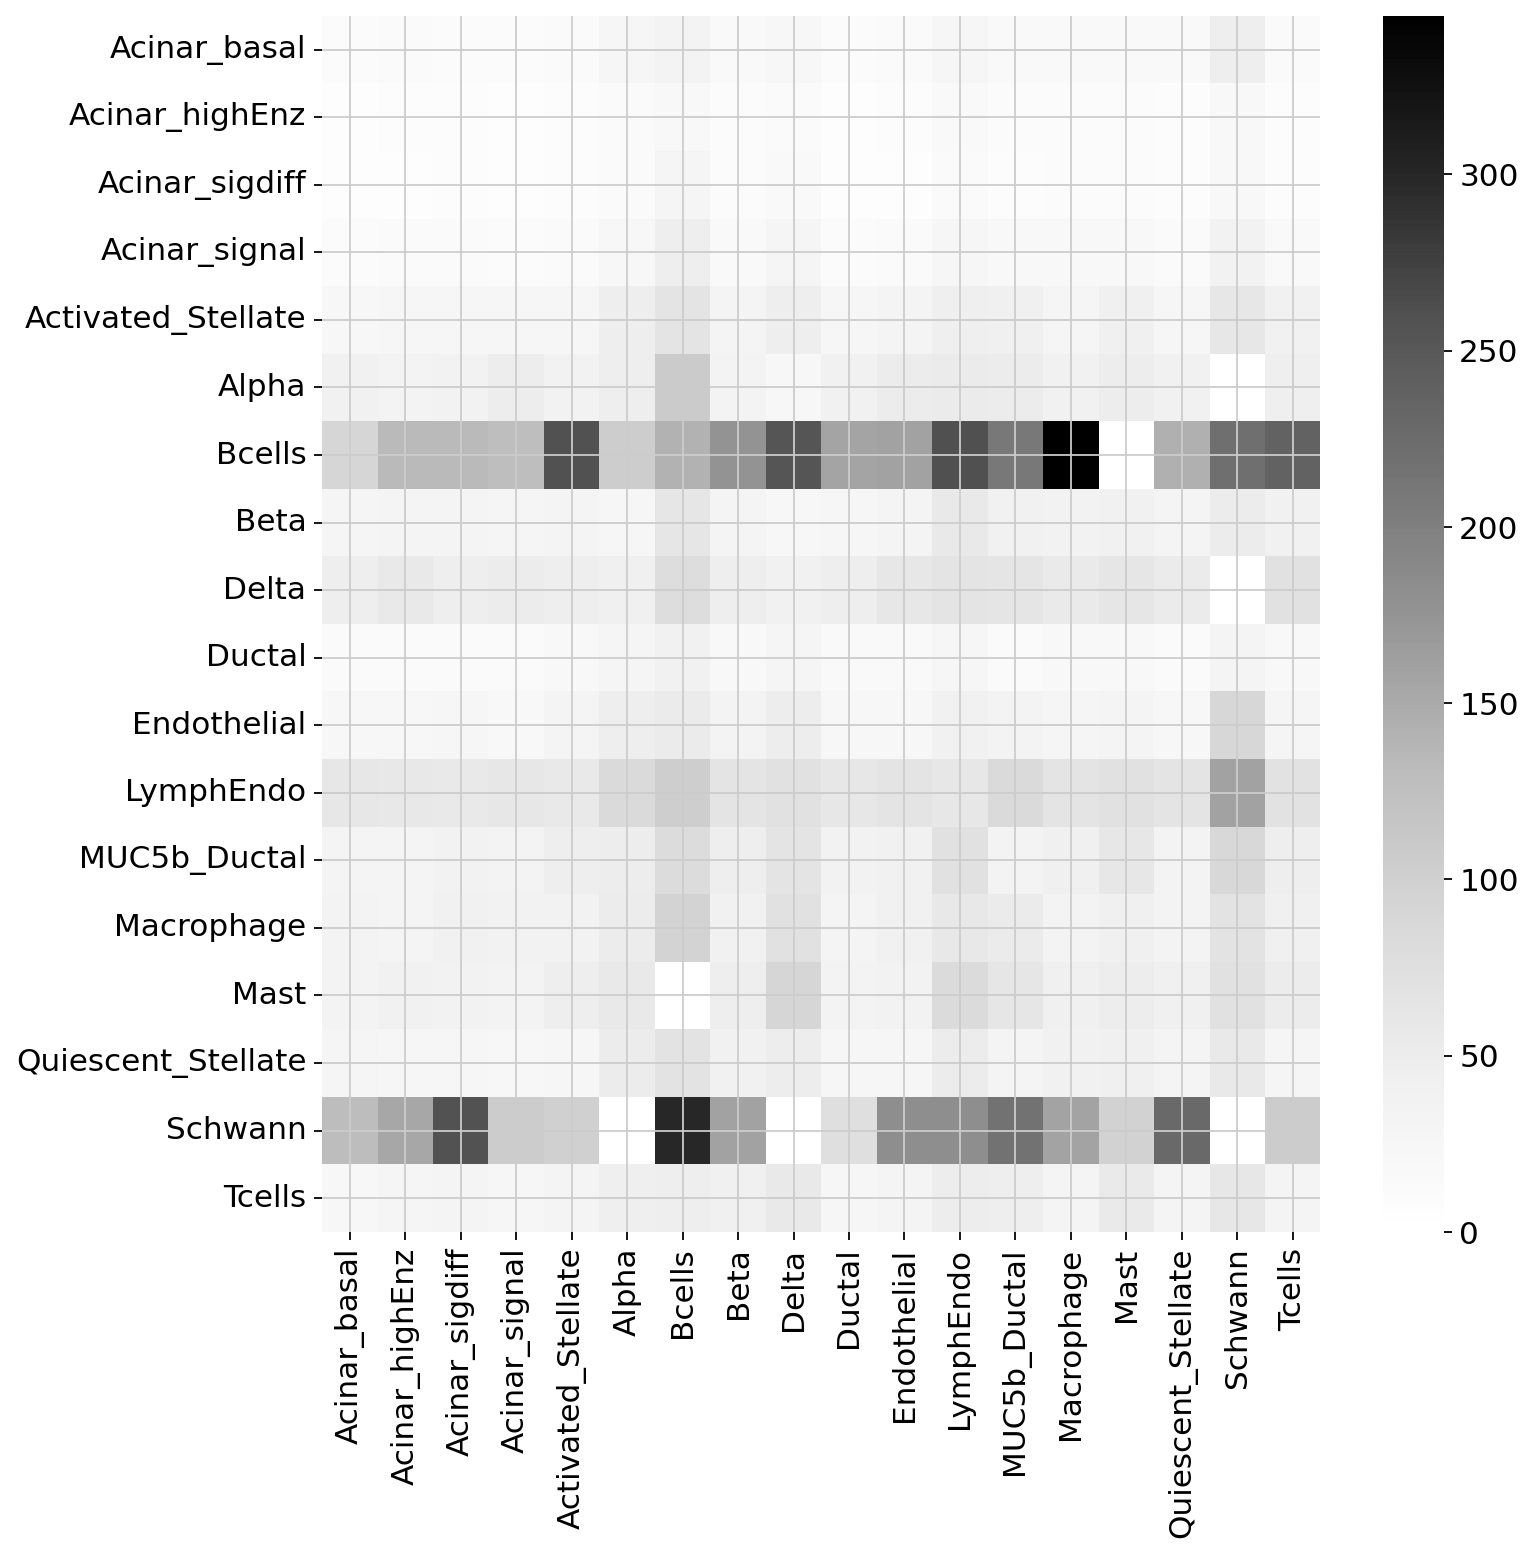

In [59]:
plt.figure(figsize=(10, 10))
sns.heatmap(df_int_10,cmap="Greys")

<Axes: >

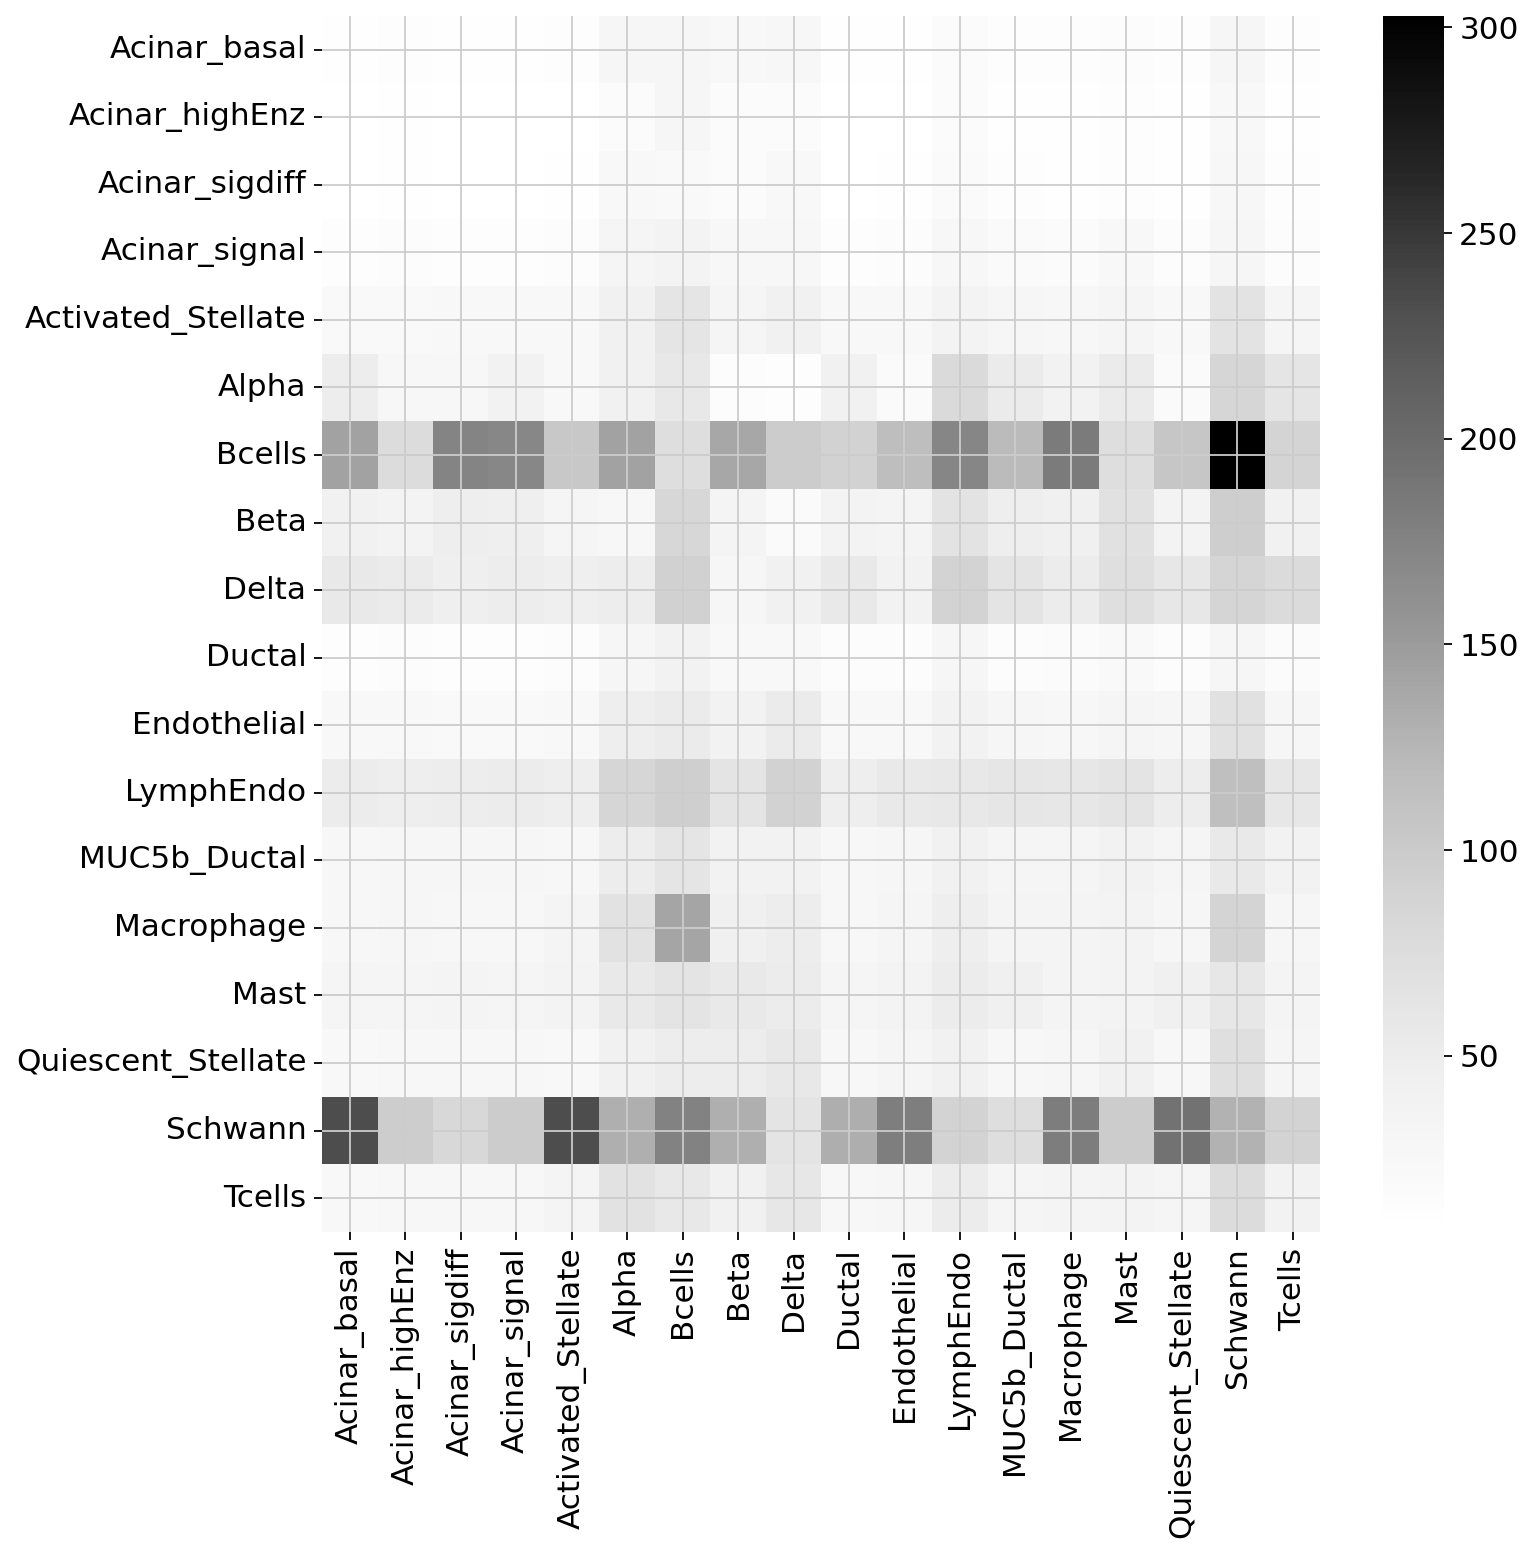

In [60]:
plt.figure(figsize=(10, 10))
sns.heatmap(df_int_12,cmap="Greys")

In [45]:
interactions = [
    #'index_Endocrine_Exocrine:neighbor_Endocrine_Exocrine',
    'index_Ductal_enriched:neighbor_Mast_enriched'
]

/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite va

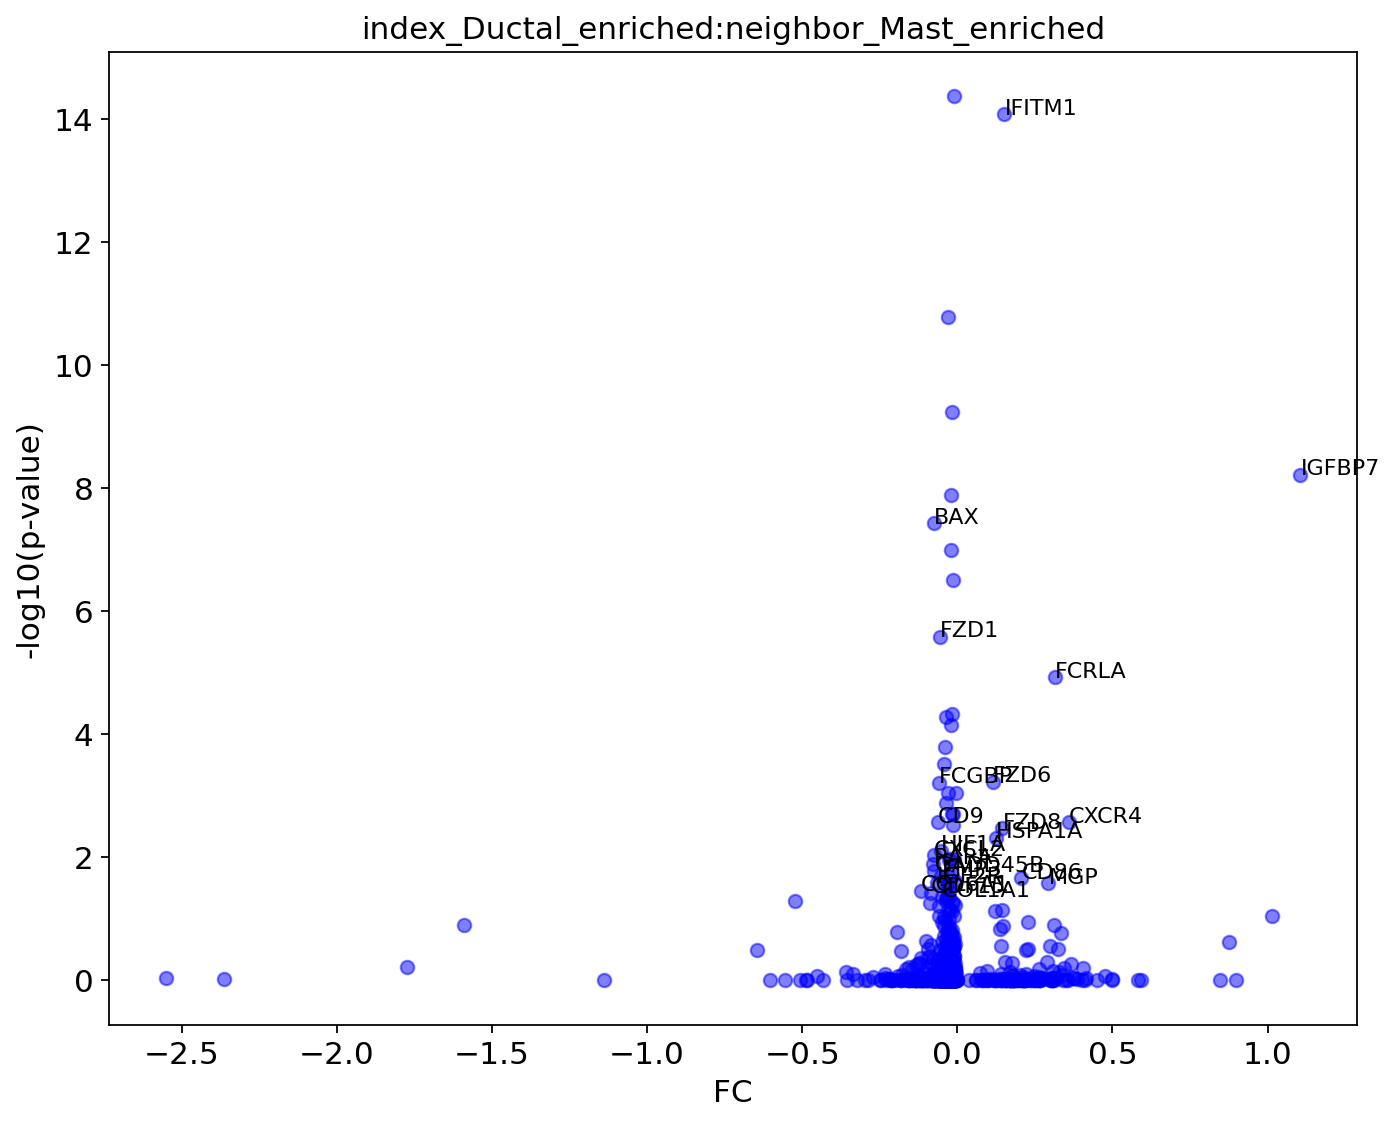

In [46]:
for c in interactions:
    data_df = {
        'log2FoldChange' : adata.varm['ncem_params'][c],
        'padj' : adata.varm['ncem_fdr_pvals'][c],
        'symbol' : np.array(adata.varm['ncem_fdr_pvals'].index)
    }
    
    df = pd.DataFrame(data_df)
    
    df['-log10(p_value)'] = -np.log10(df['padj'])
    

    plt.figure(figsize=(10, 8))
    plt.scatter(df['log2FoldChange'], df['-log10(p_value)'], color='blue', alpha=0.5)
    
    # Label the most significant points
    threshold_logFC = 0.05  # Adjust as needed
    threshold_p_value = 0.05  # Adjust as needed
    significant_points = df[(abs(df['log2FoldChange']) >= threshold_logFC) & (df['padj'] <= threshold_p_value)]
    for i, point in significant_points.iterrows():
        plt.text(point['log2FoldChange'], point['-log10(p_value)'], point['symbol'], fontsize=10)
        #volcano(df)
        
    # Add labels and title
    plt.xlabel('FC')
    plt.ylabel('-log10(p-value)')
    plt.title(c)
    
    # Show plot
    plt.grid(False)
    plt.show()

In [47]:
df

log2FoldChange          padj    symbol  -log10(p_value)
AATK           -0.048985  9.895955e-01      AATK         0.004542
ABL1            0.155021  5.087730e-01      ABL1         0.293476
ABL2           -0.124430  5.195484e-01      ABL2         0.284374
ACE            -0.025099  1.000000e+00       ACE        -0.000000
ACE2           -0.031608  9.723830e-01      ACE2         0.012163
...                  ...           ...       ...              ...
NegPrb19       -0.009605  1.073597e-02  NegPrb19         1.969159
NegPrb20       -0.025483  4.710921e-01  NegPrb20         0.326894
NegPrb21       -0.018864  1.000000e+00  NegPrb21        -0.000000
NegPrb22       -0.021874  1.013761e-07  NegPrb22         6.994064
NegPrb23       -0.013363  1.998305e-03  NegPrb23         2.699338

[979 rows x 4 columns]

In [48]:
#significant_points = df[(abs(df['log2FoldChange']) >= threshold_logFC) & (df['padj'] <= threshold_p_value)]
sp = significant_points.dropna().sort_values('-log10(p_value)', ascending=False)
# Replace infinite values with NaN
sp.replace([np.inf, -np.inf], np.nan, inplace=True)
sp.dropna(inplace=True)
sp

log2FoldChange          padj   symbol  -log10(p_value)
IFITM1         0.151719  8.360833e-15   IFITM1        14.077750
IGFBP7         1.106104  6.038680e-09   IGFBP7         8.219058
BAX           -0.075079  3.676604e-08      BAX         7.434553
FZD1          -0.057001  2.573228e-06     FZD1         5.589522
FCRLA          0.314082  1.186658e-05    FCRLA         4.925675
FZD6           0.114426  5.944240e-04     FZD6         3.225904
FCGBP         -0.059719  6.098888e-04    FCGBP         3.214749
CD9           -0.061757  2.697689e-03      CD9         2.569008
CXCR4          0.359733  2.706040e-03    CXCR4         2.567666
FZD8           0.145635  3.368262e-03     FZD8         2.472594
HSPA1A         0.125045  4.817982e-03   HSPA1A         2.317135
HIF1A         -0.052264  7.816037e-03    HIF1A         2.107013
CXCL2         -0.075818  9.198168e-03    CXCL2         2.036299
RARA          -0.077131  1.267624e-02     RARA         1.897010
GADD45B       -0.074028  1.667477e-02  GADD45B         1.777940
EMP3          -0.051138  2.003955e-02     EMP3         1.698112
CD86           0.206623  2.174955e-02     CD86         1.662550
IGF2R         -0.065964  2.586869e-02    IGF2R         1.587226
MGP            0.293727  2.661023e-02      MGP         1.574951
COL6A1        -0.118088  3.489652e-02   COL6A1         1.457218
GDF15         -0.084170  3.789138e-02    GDF15         1.421460
COL1A1        -0.050840  4.352935e-02   COL1A1         1.361218

/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/scanpy/plotting/_matrixplot.py:143: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  values_df = self.obs_tidy.groupby(level=0).mean()
/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/scanpy/plotting/_baseplot_class.py:893: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  var_names_ordered = [self.var_names[x] for x in var_names_idx_ordered]


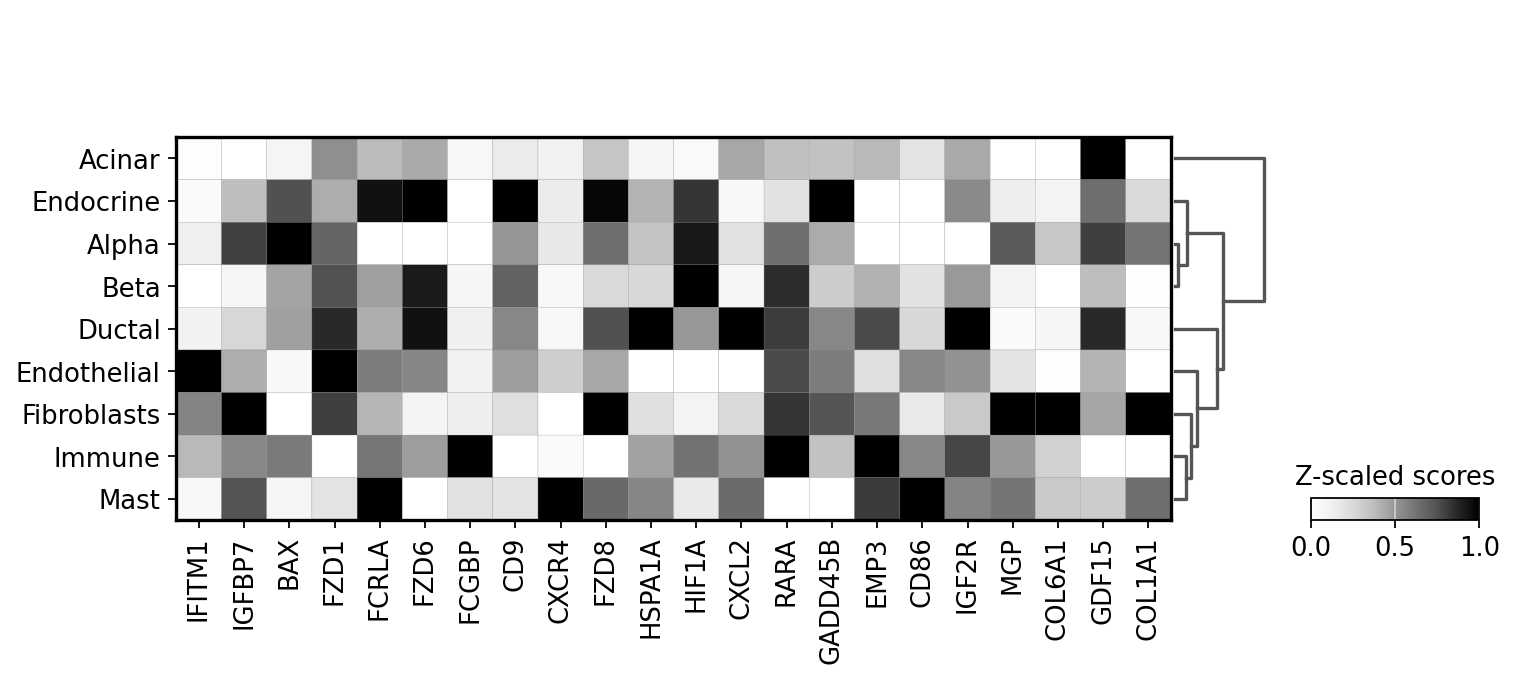

In [49]:
sc.pl.matrixplot(adata, sp['symbol'], 'cell_type_coarse', dendrogram=True, standard_scale='var',
                 colorbar_title='Z-scaled scores', cmap='Greys')